In [34]:
import pandas as pd
from google.colab import drive
from datetime import datetime
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import matplotlib.pyplot as plt
from nltk.util import ngrams
import transformers
from datetime import datetime
import json
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
#import spacy

drive.mount('/content/drive')
ts= datetime.now().strftime('%Y-%m-%d_%H-%M')
output_dir = f'/content/drive/My Drive/Colab Notebooks/output/{ts}'
os.makedirs(f"{output_dir}",exist_ok=True)

!pip install pyLDAvis
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content


In [35]:

#1) Downgrade NumPy to 1.26.x
# !pip install numpy==1.26.0 --upgrade

# # 2) Force-reinstall Gensim so it compiles against the new NumPy
# !pip install --upgrade --force-reinstall gensim

!pip install  gensim

In [36]:
## loading df that has data for the specific periods of interest     ('2020-01-01', '2020-05-31'),('2020-10-01', '2021-01-31'),('2021-11-01', '2022-01-31'),('2022-11-01','2023-01-31')

In [37]:
# Specify the path including the folder in your Google Drive
path = '/content/drive/My Drive/Colab Notebooks/selected_df.csv'
# Load the DataFrame from the CSV file
df = pd.read_csv(path)

In [38]:
df.head()

,created_utc,label,score,cleaned_text
0,2020-05-31,mild neu,0.569819,ill pay mosaic much
1,2020-05-31,mild neu,0.617377,redemption november right riding shoe either m...
2,2020-05-31,mild neu,0.610706,sure planning hilton redemption soon wouldnt s...
3,2020-05-31,mild neu,0.576460,thanks
4,2020-05-31,mild neu,0.629136,bigger w


In [39]:
!pip install contractions

In [40]:

# import nltk
# nltk.download('punkt_tab')
# !pip install -U spacy torch transformers
import spacy


In [41]:
# !python -m spacy download en_core_web_trf


In [42]:
df.shape[0]

87034

In [43]:
#drop NA
# drop any rows where cleaned_text isn’t a real string
df = df.dropna(subset=['cleaned_text'])
df.shape[0]

86446

In [44]:
## Data Cleaning with spaCy
import re, string
import pandas as pd
import contractions
import spacy

# Load spaCy's English model
nlp = spacy.load("en_core_web_sm")
# nlp = spacy.load("en_core_web_trf")
# Convert timestamp column
df['created_utc'] = pd.to_datetime(df['created_utc'])

# Define full-clean function using spaCy
def full_clean_spacy(doc):
    # Basic regex cleaning
    doc = re.sub(r'\s+', ' ', doc).strip()
    doc = doc.lower()
    doc = re.sub(r'http\S+|www\.\S+', '', doc)
    doc = re.sub(r'<.*?>',          '', doc)
    doc = re.sub(r'@\w+|#\w+',      '', doc)
    doc = contractions.fix(doc)
    doc = doc.translate(str.maketrans('', '', string.punctuation))
    doc = re.sub(r'\d+', '', doc)

    # Process with spaCy
    spacy_doc = nlp(doc)

    # Lemmatize, remove stopwords and short tokens
    tokens = [
        token.lemma_
        for token in spacy_doc
        if not token.is_stop and not token.is_punct and len(token) > 2
    ]
    return tokens

# Apply to each row
df['tokens']     = df['cleaned_text'].apply(full_clean_spacy)
df['final_text'] = df['tokens'].str.join(' ')

# Preview
df[['created_utc','score','final_text','tokens']].head()


,created_utc,score,final_text,tokens
0,2020-05-31,0.569819,ill pay mosaic,"[ill, pay, mosaic]"
1,2020-05-31,0.617377,redemption november right riding shoe move tri...,"[redemption, november, right, riding, shoe, mo..."
2,2020-05-31,0.610706,sure plan hilton redemption soon speculatively...,"[sure, plan, hilton, redemption, soon, specula..."
3,2020-05-31,0.576460,thank,[thank]
4,2020-05-31,0.629136,big,[big]


In [45]:
df.shape[0]

86446

In [46]:
# Filter the DataFrame
high_pos_df = df[df['label'] == 'mild pos']

# Convert the 'created_utc' column to datetime
high_pos_df['created_utc'] = pd.to_datetime(high_pos_df['created_utc'])

# Define your date range
# start_date = '2020-10-01'
# end_date = '2021-01-31'
start_date = '2021-11-01'
end_date = '2022-01-31'
# Filter the DataFrame for entries within the specified date range
high_pos_df = high_pos_df[(high_pos_df['created_utc'] >= start_date) & (high_pos_df['created_utc'] <= end_date)]


# Print the filtered DataFrame to check the result
high_pos_df.head()

<ipython-input-46-d2349703e64a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_pos_df['created_utc'] = pd.to_datetime(high_pos_df['created_utc'])


,created_utc,label,score,cleaned_text,tokens,final_text
44027,2022-01-31,mild pos,0.738507,wow able book confirmed suite via chase ur tra...,"[wow, able, book, confirm, suite, chase, trave...",wow able book confirm suite chase travel porta...
44054,2022-01-31,mild pos,0.680115,thanks alot info look business route recommend...,"[thank, alot, info, look, business, route, rec...",thank alot info look business route recommenda...
44059,2022-01-31,mild pos,0.575498,sure correct sweet spot route ana business cla...,"[sure, correct, sweet, spot, route, ana, busin...",sure correct sweet spot route ana business cla...
44082,2022-01-31,mild pos,0.594883,helpful strategy start negotiation booking tra...,"[helpful, strategy, start, negotiation, bookin...",helpful strategy start negotiation booking tra...
44111,2022-01-31,mild pos,0.698989,thanks look sub marriott looking referring p b...,"[thank, look, sub, marriott, look, refer, boun...",thank look sub marriott look refer boundless c...


In [47]:
high_pos_df.shape[0]

1249

      token  count
0      good    377
1    flight    366
2     point    357
3     thank    241
4      well    209
5      like    207
6      book    206
7      time    178
8       fly    169
9      look    167
10    hotel    167
11    night    159
12       go    158
13     stay    157
14    think    151
15     find    149
16      get    146
17   travel    144
18     trip    137
19      day    132
20      use    128
21      way    125
22     want    124
23   option    123
24     year    117
25    hyatt    117
26    award    117
27    great    114
28      try    109
29  airline    108


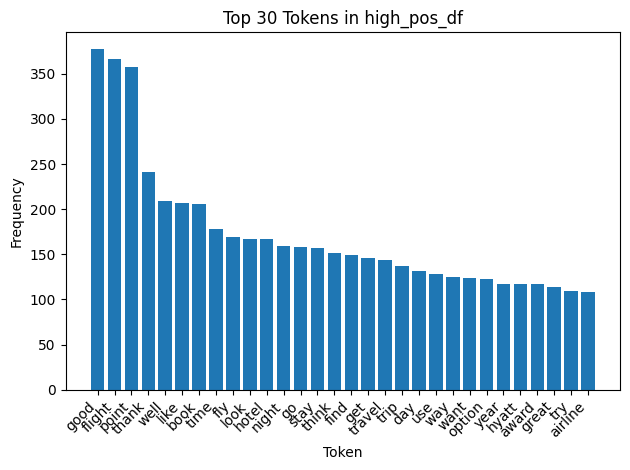

In [48]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# 1) Flatten your tokens into one long list
all_tokens = [t for toks in high_pos_df['tokens'] for t in toks]

# 2) Build a frequency distribution
freq = Counter(all_tokens)
common = freq.most_common(30)   # top 30

# 3) Turn it into a DataFrame for easy inspection
df_freq = pd.DataFrame(common, columns=['token','count'])
print(df_freq)

# 4) Plot a simple bar chart of the top tokens
tokens, counts = zip(*common)
plt.figure()
plt.bar(tokens, counts)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.title('Top 30 Tokens in high_pos_df')
plt.tight_layout()
plt.show()

In [49]:
# Flatten all tokens into one list
all_words   = [word for tokens in high_pos_df['tokens'] for word in tokens]

# Compute the length (in tokens) of each post
post_length = [len(tokens) for tokens in high_pos_df['tokens']]

# Build the vocabulary
vocab       = sorted(set(all_words))

# Print your summary stats
print(f"{len(all_words)} words total, with a vocabulary size of {len(vocab)}")
print(f"Max reddit post length is {max(post_length)} tokens")
print(f"Mean reddit post length is {sum(post_length)/len(post_length):.2f} tokens")
print(f"Median reddit post length is {sorted(post_length)[len(post_length)//2]} tokens")


25738 words total, with a vocabulary size of 4095
Max reddit post length is 170 tokens
Mean reddit post length is 20.61 tokens
Median reddit post length is 14 tokens


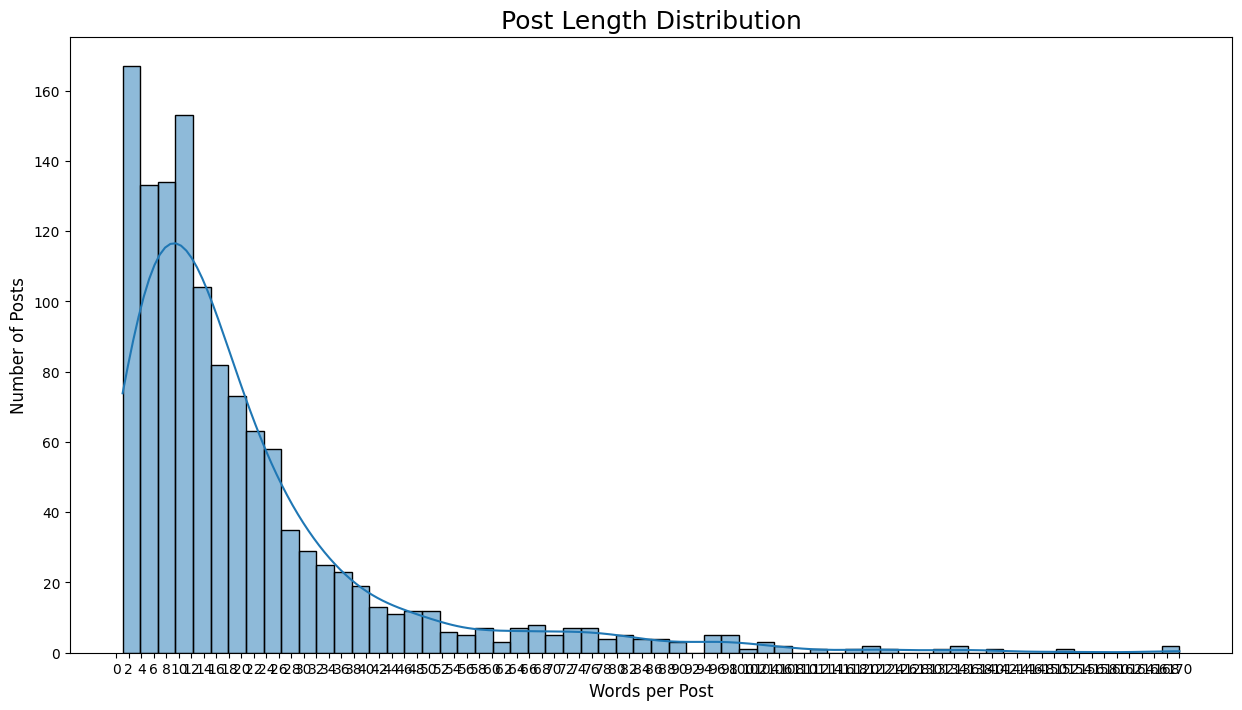

In [50]:
plt.figure(figsize=(15, 8))
sns.histplot(post_length, bins=60, kde=True)
plt.title('Post Length Distribution', fontsize=18)
plt.xlabel('Words per Post', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)
# Setting x-axis ticks and labels for more detail
max_length = max(post_length)
xticks = np.arange(0, max_length + 1, max_length // 60)
plt.xticks(xticks)
plt.show()

In [51]:

#1) Downgrade NumPy to 1.26.x
# !pip install numpy==1.26.0 --upgrade

# # 2) Force-reinstall Gensim so it compiles against the new NumPy
# !pip install --upgrade --force-reinstall gensim

!pip install  gensim



In [52]:
import gensim
from gensim.models import Phrases
from gensim.models.phrases import Phraser

# 1) Prepare your list-of-lists from the `tokens` column
texts = high_pos_df['tokens'].tolist()

# 2) Train the bigram detector
bigram = Phrases(texts, min_count=3, threshold=50)
bigram_mod = Phraser(bigram)

# 3) Train the trigram detector on the bigram-transformed texts
trigram = Phrases(bigram[texts], min_count=2, threshold=150)
trigram_mod = Phraser(trigram)

# 4) Apply bigram and trigram transforms
high_pos_df['bigram_tokens']   = high_pos_df['tokens'].apply(lambda doc: bigram_mod[doc])
high_pos_df['trigram_tokens']  = high_pos_df['tokens'].apply(lambda doc: trigram_mod[bigram_mod[doc]])

# # 5)
# high_pos_df['bigram_text']   = high_pos_df['bigram_tokens'].str.join(' ')
# high_pos_df['trigram_text']  = high_pos_df['trigram_tokens'].str.join(' ')

# 6) Inspect
print(high_pos_df[['tokens','bigram_tokens','trigram_tokens']].head())


                                                  tokens  \
44027  [wow, able, book, confirm, suite, chase, trave...   
44054  [thank, alot, info, look, business, route, rec...   
44059  [sure, correct, sweet, spot, route, ana, busin...   
44082  [helpful, strategy, start, negotiation, bookin...   
44111  [thank, look, sub, marriott, look, refer, boun...   

                                           bigram_tokens  \
44027  [wow, able, book, confirm, suite, chase, trave...   
44054  [thank, alot, info, look, business, route, rec...   
44059  [sure, correct, sweet_spot, route, ana, busine...   
44082  [helpful, strategy, start, negotiation, bookin...   
44111  [thank, look, sub, marriott, look, refer, boun...   

                                          trigram_tokens  
44027  [wow, able, book, confirm, suite, chase_travel...  
44054  [thank, alot, info, look, business, route, rec...  
44059  [sure, correct, sweet_spot, route, ana, busine...  
44082  [helpful, strategy, start, negotiat

In [53]:
# 1) Helper to detect n-grams in a token list
def contains_ngram(tokenized_list, n):
    return any(len(tok.split('_')) == n for tok in tokenized_list)

# 2) Flag rows
high_pos_df['has_bigrams']  = high_pos_df['bigram_tokens'].apply(lambda doc: contains_ngram(doc, 2))
high_pos_df['has_trigrams'] = high_pos_df['trigram_tokens'].apply(lambda doc: contains_ngram(doc, 3))

# 3) Count
rows_with_bigrams  = high_pos_df['has_bigrams'].sum()
rows_with_trigrams = high_pos_df['has_trigrams'].sum()
rows_with_none     = (~high_pos_df['has_bigrams'] & ~high_pos_df['has_trigrams']).sum()

# 4) Report
print(f"Rows with bigrams:   {rows_with_bigrams}")
print(f"Rows with trigrams:  {rows_with_trigrams}")
print(f"Rows with no n-grams: {rows_with_none}")


Rows with bigrams:   320
Rows with trigrams:  9
Rows with no n-grams: 929


In [54]:
high_pos_df.head()

,created_utc,label,score,cleaned_text,tokens,final_text,bigram_tokens,trigram_tokens,has_bigrams,has_trigrams
44027,2022-01-31,mild pos,0.738507,wow able book confirmed suite via chase ur tra...,"[wow, able, book, confirm, suite, chase, trave...",wow able book confirm suite chase travel porta...,"[wow, able, book, confirm, suite, chase, trave...","[wow, able, book, confirm, suite, chase_travel...",True,True
44054,2022-01-31,mild pos,0.680115,thanks alot info look business route recommend...,"[thank, alot, info, look, business, route, rec...",thank alot info look business route recommenda...,"[thank, alot, info, look, business, route, rec...","[thank, alot, info, look, business, route, rec...",True,False
44059,2022-01-31,mild pos,0.575498,sure correct sweet spot route ana business cla...,"[sure, correct, sweet, spot, route, ana, busin...",sure correct sweet spot route ana business cla...,"[sure, correct, sweet_spot, route, ana, busine...","[sure, correct, sweet_spot, route, ana, busine...",True,False
44082,2022-01-31,mild pos,0.594883,helpful strategy start negotiation booking tra...,"[helpful, strategy, start, negotiation, bookin...",helpful strategy start negotiation booking tra...,"[helpful, strategy, start, negotiation, bookin...","[helpful, strategy, start, negotiation, bookin...",False,False
44111,2022-01-31,mild pos,0.698989,thanks look sub marriott looking referring p b...,"[thank, look, sub, marriott, look, refer, boun...",thank look sub marriott look refer boundless c...,"[thank, look, sub, marriott, look, refer, boun...","[thank, look, sub, marriott, look, refer, boun...",False,False


In [55]:
# Print the total number of rows in the DataFrame
total_rows = high_pos_df.shape[0]
print(f"Total number of rows in the DataFrame: {total_rows}")

# Check the number of rows in the 'trigram_tokenized' column
print(f"Number of rows in 'trigram_tokenized' column: {high_pos_df['trigram_tokens'].shape[0]}")

Total number of rows in the DataFrame: 1249
Number of rows in 'trigram_tokenized' column: 1249


In [56]:
import itertools
from collections import Counter

# 1) Flatten all trigram lists into one big sequence
all_bigrams = itertools.chain.from_iterable(high_pos_df['bigram_tokens'])

# 2)
bigram_counts = Counter(
    token for token in all_bigrams
    if isinstance(token, str) and token.count('_') == 1
)

# 3) How many unique trigrams?
total_unique_bigrams = len(bigram_counts)
print(f"Total number of unique bigrams: {total_unique_bigrams}")

# 4) Show the 10 most common trigrams
print("\nMost common bigrams:")
for bigram, count in bigram_counts.most_common(10):
    print(f"{bigram}: {count:,}")


Total number of unique bigrams: 61

Most common bigrams:
good_luck: 38
business_class: 32
credit_card: 23
round_trip: 21
award_space: 21
pay_cash: 17
lie_flat: 14
park_hyatt: 11
year_ago: 11
star_alliance: 11


In [57]:
import itertools
from collections import Counter

# 1) Flatten all trigram lists into one big sequence
all_trigrams = itertools.chain.from_iterable(high_pos_df['trigram_tokens'])

# 2) Filter for genuine trigrams (exactly two underscores → three words joined)
trigram_counts = Counter(
    token for token in all_trigrams
    if isinstance(token, str) and token.count('_') == 2
)

# 3) How many unique trigrams?
total_unique_trigrams = len(trigram_counts)
print(f"Total number of unique trigrams: {total_unique_trigrams}")

# 4) Show the 10 most common trigrams
print("\nMost common trigrams:")
for trigram, count in trigram_counts.most_common(10):
    print(f"{trigram}: {count:,}")


Total number of unique trigrams: 2

Most common trigrams:
chase_travel_portal: 5
lie_flat_seat: 4


In [58]:
# import gensim.corpora as corpora
# # Create Dictionary
# id2word = corpora.Dictionary(high_pos_df['trigram_tokens'].tolist())

# ## pruning
# #id2word.filter_extremes(no_below=5, no_above=0.5)

# #    (Optional) Re-map the remaining token IDs to remove gaps
# #id2word.compactify()

# # 2. Convert each document to a Bag-of-Words
# texts = high_pos_df['trigram_tokens'].tolist()

# # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]


# # View
# print(corpus[:1][0][:30])

In [59]:
# import gensim
# from gensim import corpora
# from gensim.models.ldamodel import LdaModel
# from nltk.tokenize import word_tokenize
# import nltk
# ## Build the basic LDA model
# lda_model = LdaModel(corpus=corpus,
#                                        id2word=id2word,
#                                        num_topics=4,
#                                        random_state=100,
#                                        chunksize=250,
#                                        passes=200,
#                                         iterations= 100,
#                                        alpha='auto',
#                                       eta='auto',
#                                        per_word_topics=True)

In [60]:
# from pprint import pprint

# # Print the Keyword in the 3 topics
# pprint(lda_model.print_topics())
# doc_lda = lda_model[corpus]

In [61]:
# from gensim.models import CoherenceModel
# #
# # Compute Coherence Score
# coherence_model_lda = CoherenceModel(model=lda_model, texts=high_pos_df['trigram_tokenized'], dictionary=id2word, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()
# print('Coherence Score: ', coherence_lda)

In [62]:
# import pyLDAvis.gensim
# import pickle
# import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis
# import pyLDAvis

# # Assuming ldamodel, corpus, and dictionary are already defined
# # Enable the automatic display of visualizations in Jupyter
# pyLDAvis.enable_notebook()

# # Prepare the LDA visualization directly
# LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)

# # Display the prepared visualization directly in the notebook
# pyLDAvis.display(LDAvis_prepared)

In [63]:
# # Extracting and printing the top 30 salient terms for each topic
# num_topics = lda_model.num_topics
# num_words = 30

# for idx, topic in lda_model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False):
#     print(f"Topic {idx + 1}:")
#     for word, weight in topic:
#         print(f"  {word} ({weight:.4f})")
#     print()

In [64]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pandas as pd
import numpy as np
import itertools

# Assuming high_pos_df['trigram_tokenized'] contains lists of lemmatized trigram tokens
texts = high_pos_df['trigram_tokens'].tolist()

# Create a Dictionary and Corpus
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Function to compute coherence and perplexity
def compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations,seed):
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=seed,
                         chunksize=chunksize,
                         passes=passes,
                         iterations=iterations,
                         alpha='auto',
                         eta='auto',
                         per_word_topics=True)

    perplexity = lda_model.log_perplexity(corpus)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model_lda.get_coherence()
     # Extract alpha and eta
    alpha = lda_model.alpha
    eta = lda_model.eta
    return perplexity, coherence, alpha, eta

# Define the parameter grid with your specific values
seeds = [0, 1, 2]
num_topics_range = range(2, 10)  # Adjust the range based on your needs
chunksize_range = [1000]
passes_range = [100, 200,260]
iterations_range = [50, 100, 200]

# Store results
results = []

# Grid search over all combinations of hyperparameters
for seed in [0, 1, 2]:
  for num_topics, chunksize, passes, iterations in itertools.product(num_topics_range, chunksize_range, passes_range, iterations_range):
    perplexity, coherence, alpha, eta = compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations, seed)
    results.append((num_topics, chunksize, passes, iterations, perplexity, coherence, alpha, eta, seed))
    # print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f}"  f"Alpha: {alpha}, Eta: {eta}")

print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, "
      f"Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f}, Alpha: {alpha}, Eta: {eta}")

# Convert results to a DataFrame for better analysis
results_df = pd.DataFrame(results, columns=['num_topics', 'chunksize', 'passes', 'iterations', 'perplexity', 'coherence','alpha','eta','seed'])
# Add exponentiated perplexity column
results_df['perplexity_exp'] = np.exp(-results_df['perplexity'])


# Display results
print("\nResults:")
print(results_df)

# Find the optimal number of topics with the highest coherence
optimal_result = results_df.sort_values(
    by=['coherence', 'perplexity_exp'],
    ascending=[False, True]
).iloc[0]
optimal_num_topics = optimal_result['num_topics']
optimal_chunksize = optimal_result['chunksize']
optimal_passes = optimal_result['passes']
optimal_iterations = optimal_result['iterations']
optimal_perplexity = optimal_result['perplexity_exp']
optimal_coherence = optimal_result['coherence']
optimal_alpha = optimal_result['alpha']
optimal_eta   = optimal_result['eta']
optimal_seed = optimal_result['seed']



print(f"\nOptimal Parameters:")
print(f"Number of Topics: {optimal_num_topics}")
print(f"Chunksize: {optimal_chunksize}")
print(f"Passes: {optimal_passes}")
print(f"Iterations: {optimal_iterations}")
print(f"Coherence: {optimal_coherence:.4f}")
print(f"Perplexity: {optimal_perplexity:.4f}")
print(f" Alpha (per topic): {optimal_alpha}")
print(f" Eta   (per word):  {optimal_eta}")
print(f" seed:  {optimal_seed}")

Num Topics: 9, Chunksize: 1000, Passes: 260, Iterations: 200, Perplexity: -7.5895, Coherence: 0.4322, Alpha: [0.0771904  0.02926578 0.08195166 0.04369611 0.12633885 0.38430566
 0.06651656 0.03184962 0.05322613], Eta: [0.15386628 0.1080493  0.15303773 ... 0.1066377  0.1066377  0.10663862]

Results:
     num_topics  chunksize  passes  iterations  perplexity  coherence  \
0             2       1000     100          50   -7.293887   0.505363   
1             2       1000     100         100   -7.292380   0.532108   
2             2       1000     100         200   -7.291372   0.532108   
3             2       1000     200          50   -7.289720   0.505363   
4             2       1000     200         100   -7.285568   0.532108   
..          ...        ...     ...         ...         ...        ...   
211           9       1000     200         100   -7.589487   0.431597   
212           9       1000     200         200   -7.590749   0.432172   
213           9       1000     260          

In [65]:
# 1. Fit the model
lda_opt = LdaModel(
    corpus        = corpus,
    id2word       = dictionary,
    num_topics    = optimal_num_topics,
    chunksize     = optimal_chunksize,
    passes        = optimal_passes,
    iterations    = optimal_iterations,
    alpha         = 'auto',
    eta           = 'auto',
    random_state  = optimal_seed,
    per_word_topics=True
)

# 2. Extract metrics and priors
opt_perp  = lda_opt.log_perplexity(corpus)
opt_coh   = CoherenceModel(model=lda_opt, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
opt_alpha = lda_opt.alpha
opt_eta   = lda_opt.eta

print(f"Re-fitted Optimal Model:")
print(f" Coherence: {opt_coh:.4f}")
print(f" Perplexity: {opt_perp:.4f}")
print(f" Alpha (per topic): {opt_alpha}")
print(f" Eta   (per word):  {opt_eta}")


Re-fitted Optimal Model:
 Coherence: 0.5809
 Perplexity: -7.3207
 Alpha (per topic): [0.03257319 0.03223645 0.03636515]
 Eta   (per word):  [ 5.530913    0.376197   10.069293   ...  0.33707717  0.33707717
  0.33708352]


In [67]:
import numpy as np
from google.colab import files

# 1. Grab your metrics & hyper‐params
coherence_val  = opt_coh
perplexity_val = opt_perp
alpha_val      = opt_alpha
eta_vals       = opt_eta  # full array


with open('lda_model_full_summary_3rd_mild_pos.txt', 'w') as f:
    f.write("Re-fitted Optimal Model:\n")
    f.write(f" Coherence:  {coherence_val:.4f}\n")
    f.write(f" Perplexity: {perplexity_val:.4f}\n")
    f.write(f" Alpha:      {alpha_val}\n")
    f.write(" Eta values:\n")
    for eta in eta_vals:
        f.write(f"{eta}\n")
    f.flush()  # Ensure it's written to disk

files.download('lda_model_full_summary_3rd_mild_pos.txt')



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [68]:
# : verify that the refit recovered the same priors
import numpy as np

print("Alpha match:", np.allclose(optimal_alpha, opt_alpha))
print("Eta   match:", np.allclose(optimal_eta,   opt_eta))


Alpha match: True
Eta   match: True


In [69]:
# : Imports
from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Print topics & sample document–topic distribution
print("=== Topics ===")
pprint(lda_opt.print_topics())

doc_topics = [lda_opt.get_document_topics(doc) for doc in corpus]
print("\nSample doc-topic distribution for doc 0:")
pprint(doc_topics[0])



=== Topics ===
[(0,
  '0.020*"point" + 0.012*"good" + 0.010*"hotel" + 0.010*"night" + 0.010*"stay" '
  '+ 0.008*"book" + 0.008*"well" + 0.007*"think" + 0.006*"hyatt" + '
  '0.006*"room"'),
 (1,
  '0.032*"thank" + 0.011*"seat" + 0.010*"flight" + 0.009*"good" + 0.008*"fly" '
  '+ 0.008*"like" + 0.007*"hour" + 0.007*"get" + 0.007*"fine" + 0.007*"time"'),
 (2,
  '0.032*"flight" + 0.013*"good" + 0.013*"fly" + 0.010*"airline" + '
  '0.008*"like" + 0.007*"time" + 0.007*"find" + 0.007*"thank" + 0.006*"look" + '
  '0.006*"book"')]

Sample doc-topic distribution for doc 0:
[(0, 0.9964074)]


In [70]:
#  pyLDAvis visualization
# (make sure you’ve run `%matplotlib inline` or enabled notebook output)
pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_opt, corpus, dictionary)
pyLDAvis.display(vis_data)


In [71]:
# Cell 4: Print the top 30 terms per topic
print("\n=== Top 30 terms per topic ===")
for topic_id, term_weights in lda_opt.show_topics(
        num_topics=lda_opt.num_topics,
        num_words=30,
        formatted=False):
    print(f"Topic {topic_id + 1}:")
    for word, weight in term_weights:
        print(f"  {word} ({weight:.4f})")
    print()



=== Top 30 terms per topic ===
Topic 1:
  point (0.0197)
  good (0.0118)
  hotel (0.0099)
  night (0.0099)
  stay (0.0098)
  book (0.0083)
  well (0.0082)
  think (0.0071)
  hyatt (0.0065)
  room (0.0059)
  use (0.0058)
  time (0.0057)
  like (0.0055)
  want (0.0055)
  day (0.0055)
  trip (0.0052)
  free (0.0050)
  value (0.0050)
  nice (0.0049)
  year (0.0047)
  card (0.0046)
  way (0.0045)
  get (0.0045)
  go (0.0044)
  marriott (0.0044)
  hilton (0.0043)
  travel (0.0043)
  upgrade (0.0042)
  great (0.0042)
  look (0.0038)

Topic 2:
  thank (0.0322)
  seat (0.0111)
  flight (0.0101)
  good (0.0086)
  fly (0.0076)
  like (0.0075)
  hour (0.0073)
  get (0.0070)
  fine (0.0067)
  time (0.0066)
  go (0.0061)
  ill (0.0061)
  way (0.0057)
  yes (0.0057)
  look (0.0056)
  ticket (0.0054)
  need (0.0049)
  gift (0.0045)
  airline (0.0044)
  economy (0.0043)
  travel (0.0043)
  think (0.0041)
  check (0.0041)
  help (0.0040)
  work (0.0040)
  price (0.0038)
  give (0.0038)
  well (0.0038)


In [72]:
# import gensim.corpora as corpora
# # # Create Dictionary
# id2word = corpora.Dictionary(high_pos_df['trigram_tokens'].tolist())

# # ## pruning
# id2word.filter_extremes(no_below=5, no_above=0.7)

# # #    (Optional) Re-map the remaining token IDs to remove gaps
# id2word.compactify()

# # # 2. Convert each document to a Bag-of-Words
# texts = high_pos_df['trigram_tokens'].tolist()

# # # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]


# # # View
# print(corpus[:1][0][:30])

In [73]:
# import gensim
# from gensim import corpora
# from gensim.models import LdaModel
# from gensim.models.coherencemodel import CoherenceModel
# import pandas as pd
# import numpy as np
# import itertools


# # Create a Dictionary and Corpus
# dictionary = id2word


# # Function to compute coherence and perplexity
# def compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations):
#     lda_model = LdaModel(corpus=corpus,
#                          id2word=dictionary,
#                          num_topics=num_topics,
#                          random_state=100,
#                          chunksize=chunksize,
#                          passes=passes,
#                          iterations=iterations,
#                          alpha='auto',
#                          eta='auto',
#                          per_word_topics=True)

#     perplexity = lda_model.log_perplexity(corpus)
#     coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
#     coherence = coherence_model_lda.get_coherence()
#      # Extract alpha and eta
#     alpha = lda_model.alpha
#     eta = lda_model.eta
#     return perplexity, coherence, alpha, eta

# # Define the parameter grid with your specific values
# num_topics_range = range(2, 10)  # Adjust the range based on your needs
# chunksize_range = [250]
# passes_range = [100, 200,260]
# iterations_range = [50, 100, 200]

# # Store results
# results = []

# # Grid search over all combinations of hyperparameters
# for num_topics, chunksize, passes, iterations in itertools.product(num_topics_range, chunksize_range, passes_range, iterations_range):
#     perplexity, coherence, alpha, eta = compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations)
#     results.append((num_topics, chunksize, passes, iterations, perplexity, coherence, alpha, eta))
#     # print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f}"  f"Alpha: {alpha}, Eta: {eta}")

# print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, "
#       f"Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f}, Alpha: {alpha}, Eta: {eta}")

# # Convert results to a DataFrame for better analysis
# results_df = pd.DataFrame(results, columns=['num_topics', 'chunksize', 'passes', 'iterations', 'perplexity', 'coherence','alpha','eta'])
# # Add exponentiated perplexity column
# results_df['perplexity_exp'] = np.exp(-results_df['perplexity'])


# # Display results
# print("\nResults:")
# print(results_df)

# # Find the optimal number of topics with the highest coherence
# optimal_result = results_df.sort_values(
#     by=['coherence', 'perplexity_exp'],
#     ascending=[False, True]
# ).iloc[0]
# optimal_num_topics = optimal_result['num_topics']
# optimal_chunksize = optimal_result['chunksize']
# optimal_passes = optimal_result['passes']
# optimal_iterations = optimal_result['iterations']
# optimal_perplexity = optimal_result['perplexity_exp']
# optimal_coherence = optimal_result['coherence']
# optimal_alpha = optimal_result['alpha']
# optimal_eta   = optimal_result['eta']


# print(f"\nOptimal Parameters:")
# print(f"Number of Topics: {optimal_num_topics}")
# print(f"Chunksize: {optimal_chunksize}")
# print(f"Passes: {optimal_passes}")
# print(f"Iterations: {optimal_iterations}")
# print(f"Coherence: {optimal_coherence:.4f}")
# print(f"Perplexity: {optimal_perplexity:.4f}")
# print(f" Alpha (per topic): {optimal_alpha}")
# print(f" Eta   (per word):  {optimal_eta}")

In [74]:
# # 1. Fit the model
# lda_opt = LdaModel(
#     corpus        = corpus,
#     id2word       = dictionary,
#     num_topics    = optimal_num_topics,
#     chunksize     = optimal_chunksize,
#     passes        = optimal_passes,
#     iterations    = optimal_iterations,
#     alpha         = 'auto',
#     eta           = 'auto',
#     random_state  = 100,
#     per_word_topics=True
# )

# # 2. Extract metrics and priors
# opt_perp  = lda_opt.log_perplexity(corpus)
# opt_coh   = CoherenceModel(model=lda_opt, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
# opt_alpha = lda_opt.alpha
# opt_eta   = lda_opt.eta

# print(f"Re-fitted Optimal Model:")
# print(f" Coherence: {opt_coh:.4f}")
# print(f" Perplexity: {opt_perp:.4f}")
# print(f" Alpha (per topic): {opt_alpha}")
# print(f" Eta   (per word):  {opt_eta}")


In [75]:
# import numpy as np
# from google.colab import files

# # 1. Grab your metrics & hyper‐params
# coherence_val  = opt_coh
# perplexity_val = opt_perp
# alpha_val      = opt_alpha
# eta_vals       = opt_eta  # full array

# # 2. Write them into a single text file
# with open('lda_model_full_summary.txt', 'w') as f:
#     f.write("Re-fitted Optimal Model:\n")
#     f.write(f" Coherence:  {coherence_val:.4f}\n")
#     f.write(f" Perplexity: {perplexity_val:.4f}\n")
#     f.write(f" Alpha:      {alpha_val}\n")
#     f.write(" Eta values:\n")
#     for eta in eta_vals:
#         f.write(f"{eta}\n")

# # 3. Trigger the download
# files.download('lda_model_full_summary.txt')


In [76]:
# # Cell 3: verify that the refit recovered the same priors
# import numpy as np

# print("Alpha match:", np.allclose(optimal_alpha, opt_alpha))
# print("Eta   match:", np.allclose(optimal_eta,   opt_eta))


In [77]:
# # Cell 1: Imports
# from pprint import pprint
# import pyLDAvis.gensim_models as gensimvis
# import pyLDAvis

# # Cell 2: Print topics & sample document–topic distribution
# print("=== Topics ===")
# pprint(lda_opt.print_topics())

# doc_topics = [lda_opt.get_document_topics(doc) for doc in corpus]
# print("\nSample doc-topic distribution for doc 0:")
# pprint(doc_topics[0])



In [78]:
# # Cell 3: pyLDAvis visualization
# # (make sure you’ve run `%matplotlib inline` or enabled notebook output)
# pyLDAvis.enable_notebook()
# vis_data = gensimvis.prepare(lda_opt, corpus, dictionary)
# pyLDAvis.display(vis_data)


In [79]:
# # Cell 4: Print the top 30 terms per topic
# print("\n=== Top 30 terms per topic ===")
# for topic_id, term_weights in lda_opt.show_topics(
#         num_topics=lda_opt.num_topics,
#         num_words=30,
#         formatted=False):
#     print(f"Topic {topic_id + 1}:")
#     for word, weight in term_weights:
#         print(f"  {word} ({weight:.4f})")
#     print()


In [80]:
####### HIGH NEGATIVE FOR FIRST COVID WAVE ########
# Filter the DataFrame
high_neg_first_wave_df = df[df['label'] == 'mild neg']

# Convert the 'created_utc' column to datetime
high_neg_first_wave_df['created_utc'] = pd.to_datetime(high_neg_first_wave_df['created_utc'])

# Define your date range
# start_date = '2020-01-01'
# end_date = '2020-05-31'
# Define your date range
# start_date = '2020-10-01'
# end_date = '2021-01-31'
start_date = '2021-11-01'
end_date = '2022-01-31'
# Filter the DataFrame for entries within the specified date range
high_neg_first_wave_df = high_neg_first_wave_df[(high_neg_first_wave_df['created_utc'] >= start_date) & (high_neg_first_wave_df['created_utc'] <= end_date)]


# Print the filtered DataFrame to check the result
high_neg_first_wave_df.head()

<ipython-input-80-b301ffe78fec>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_neg_first_wave_df['created_utc'] = pd.to_datetime(high_neg_first_wave_df['created_utc'])


,created_utc,label,score,cleaned_text,tokens,final_text
44049,2022-01-31,mild neg,0.713909,one hand sure hand theyre already proved weren...,"[hand, sure, hand, prove, handle, cancel, rese...",hand sure hand prove handle cancel reservation...
44063,2022-01-31,mild neg,0.668321,think misunderstanding whole situation,"[think, misunderstand, situation]",think misunderstand situation
44098,2022-01-31,mild neg,0.601575,seem misunderstanding happening try reading th...,"[misunderstand, happen, try, read, thread]",misunderstand happen try read thread
44101,2022-01-31,mild neg,0.574035,yes didnt read sidebar obvious post removed ab...,"[yes, read, sidebar, obvious, post, remove, ab...",yes read sidebar obvious post remove able book...
44124,2022-01-31,mild neg,0.589288,thanks wasnt sure sub put question ill delete one,"[thank, sure, sub, question, ill, delete]",thank sure sub question ill delete


In [81]:
high_neg_first_wave_df.shape[0]

1157

      token  count
0    flight    351
1   airline    226
2      time    195
3      like    172
4      book    157
5     point    149
6    ticket    147
7    cancel    141
8       try    139
9    people    127
10   travel    116
11      way    114
12     know    112
13      fly    106
14    think    102
15      day    102
16     find     98
17     want     98
18      get     97
19      bad     96
20       go     93
21     need     91
22  airport     91
23     look     88
24     hour     87
25    check     86
26     good     76
27    issue     74
28   change     73
29    thing     72


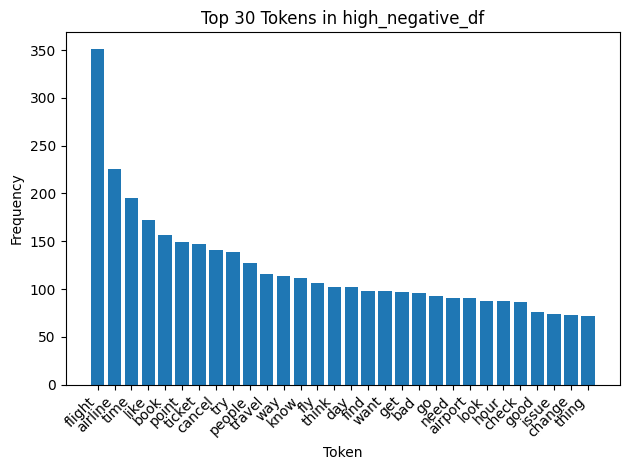

In [82]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# 1) Flatten your tokens into one long list
all_tokens = [t for toks in high_neg_first_wave_df['tokens'] for t in toks]

# 2) Build a frequency distribution
freq = Counter(all_tokens)
common = freq.most_common(30)   # top 30

# 3) Turn it into a DataFrame for easy inspection
df_freq = pd.DataFrame(common, columns=['token','count'])
print(df_freq)

# 4) Plot a simple bar chart of the top tokens
tokens, counts = zip(*common)
plt.figure()
plt.bar(tokens, counts)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.title('Top 30 Tokens in high_negative_df')
plt.tight_layout()
plt.show()

In [83]:
# Flatten all tokens into one list
all_words   = [word for tokens in high_neg_first_wave_df['tokens'] for word in tokens]

# Compute the length (in tokens) of each post
post_length = [len(tokens) for tokens in high_neg_first_wave_df['tokens']]

# Build the vocabulary
vocab       = sorted(set(all_words))

# Print your summary stats
print(f"{len(all_words)} words total, with a vocabulary size of {len(vocab)}")
print(f"Max reddit post length is {max(post_length)} tokens")
print(f"Mean reddit post length is {sum(post_length)/len(post_length):.2f} tokens")
print(f"Median reddit post length is {sorted(post_length)[len(post_length)//2]} tokens")


19549 words total, with a vocabulary size of 3721
Max reddit post length is 219 tokens
Mean reddit post length is 16.90 tokens
Median reddit post length is 13 tokens


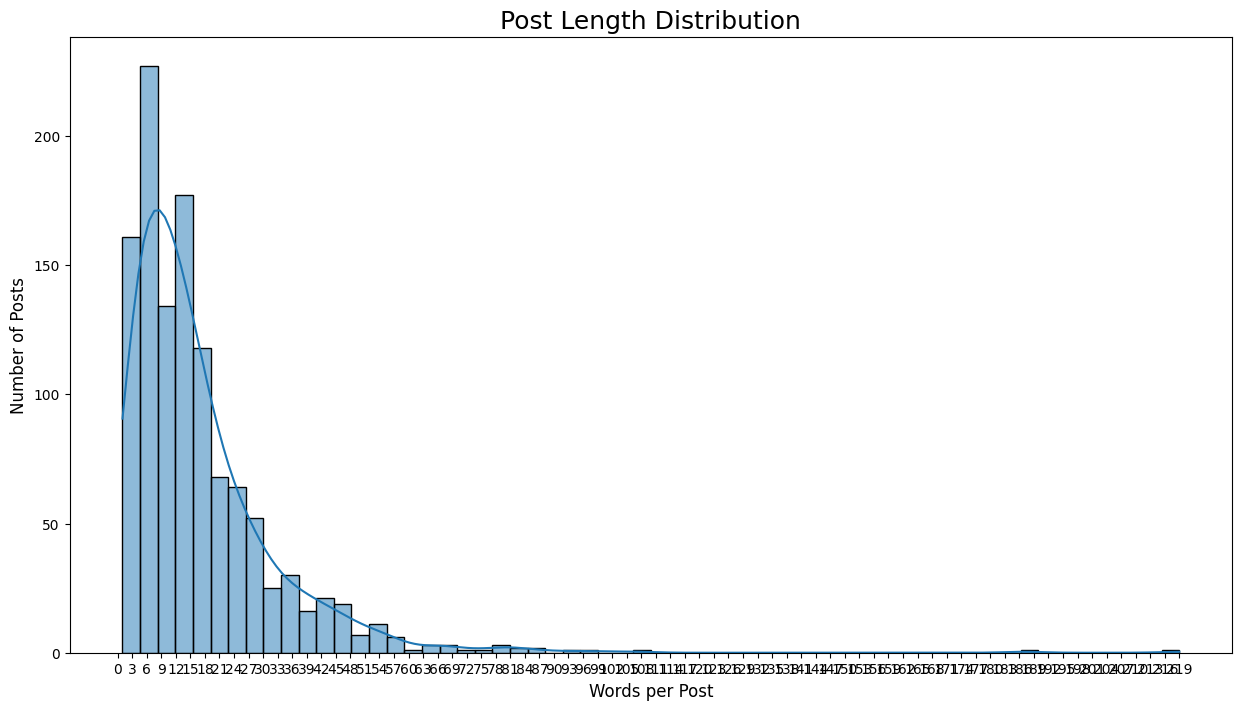

In [84]:
plt.figure(figsize=(15, 8))
sns.histplot(post_length, bins=60, kde=True)
plt.title('Post Length Distribution', fontsize=18)
plt.xlabel('Words per Post', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)
# Setting x-axis ticks and labels for more detail
max_length = max(post_length)
xticks = np.arange(0, max_length + 1, max_length // 60)
plt.xticks(xticks)
plt.show()

In [85]:
#!pip install  gensim


In [86]:
import gensim
from gensim.models import Phrases
from gensim.models.phrases import Phraser

# 1) Prepare your list-of-lists from the `tokens` column
texts = high_neg_first_wave_df['tokens'].tolist()

# 2) Train the bigram detector
bigram = Phrases(texts, min_count=3, threshold=60)
bigram_mod = Phraser(bigram)

# 3) Train the trigram detector on the bigram-transformed texts
trigram = Phrases(bigram[texts], min_count=2, threshold=150)
trigram_mod = Phraser(trigram)

# 4) Apply bigram and trigram transforms
high_neg_first_wave_df['bigram_tokens']   = high_neg_first_wave_df['tokens'].apply(lambda doc: bigram_mod[doc])
high_neg_first_wave_df['trigram_tokens']  = high_neg_first_wave_df['tokens'].apply(lambda doc: trigram_mod[bigram_mod[doc]])

# #
# high_neg_first_wave_df['bigram_text']   = high_neg_first_wave_df['bigram_tokens'].str.join(' ')
# high_neg_first_wave_df['trigram_text']  = high_neg_first_wave_df['trigram_tokens'].str.join(' ')

# 6) Inspect
print(high_neg_first_wave_df[['tokens','bigram_tokens','trigram_tokens']].head())


                                                  tokens  \
44049  [hand, sure, hand, prove, handle, cancel, rese...   
44063                  [think, misunderstand, situation]   
44098         [misunderstand, happen, try, read, thread]   
44101  [yes, read, sidebar, obvious, post, remove, ab...   
44124          [thank, sure, sub, question, ill, delete]   

                                           bigram_tokens  \
44049  [hand, sure, hand, prove, handle, cancel, rese...   
44063                  [think, misunderstand, situation]   
44098         [misunderstand, happen, try, read, thread]   
44101  [yes, read, sidebar, obvious, post, remove, ab...   
44124          [thank, sure, sub, question, ill, delete]   

                                          trigram_tokens  
44049  [hand, sure, hand, prove, handle, cancel, rese...  
44063                  [think, misunderstand, situation]  
44098         [misunderstand, happen, try, read, thread]  
44101  [yes, read, sidebar, obvious, post,

In [87]:
# 1) Helper to detect n-grams in a token list
def contains_ngram(tokenized_list, n):
    return any(len(tok.split('_')) == n for tok in tokenized_list)

# 2) Flag rows
high_neg_first_wave_df['has_bigrams']  = high_neg_first_wave_df['bigram_tokens'].apply(lambda doc: contains_ngram(doc, 2))
high_neg_first_wave_df['has_trigrams'] = high_neg_first_wave_df['trigram_tokens'].apply(lambda doc: contains_ngram(doc, 3))

# 3) Count
rows_with_bigrams  = high_neg_first_wave_df['has_bigrams'].sum()
rows_with_trigrams = high_neg_first_wave_df['has_trigrams'].sum()
rows_with_none     = (~high_neg_first_wave_df['has_bigrams'] & ~high_neg_first_wave_df['has_trigrams']).sum()

# 4) Report
print(f"Rows with bigrams:   {rows_with_bigrams}")
print(f"Rows with trigrams:  {rows_with_trigrams}")
print(f"Rows with no n-grams: {rows_with_none}")


Rows with bigrams:   205
Rows with trigrams:  0
Rows with no n-grams: 952


In [88]:
high_neg_first_wave_df.head()

,created_utc,label,score,cleaned_text,tokens,final_text,bigram_tokens,trigram_tokens,has_bigrams,has_trigrams
44049,2022-01-31,mild neg,0.713909,one hand sure hand theyre already proved weren...,"[hand, sure, hand, prove, handle, cancel, rese...",hand sure hand prove handle cancel reservation...,"[hand, sure, hand, prove, handle, cancel, rese...","[hand, sure, hand, prove, handle, cancel, rese...",False,False
44063,2022-01-31,mild neg,0.668321,think misunderstanding whole situation,"[think, misunderstand, situation]",think misunderstand situation,"[think, misunderstand, situation]","[think, misunderstand, situation]",False,False
44098,2022-01-31,mild neg,0.601575,seem misunderstanding happening try reading th...,"[misunderstand, happen, try, read, thread]",misunderstand happen try read thread,"[misunderstand, happen, try, read, thread]","[misunderstand, happen, try, read, thread]",False,False
44101,2022-01-31,mild neg,0.574035,yes didnt read sidebar obvious post removed ab...,"[yes, read, sidebar, obvious, post, remove, ab...",yes read sidebar obvious post remove able book...,"[yes, read, sidebar, obvious, post, remove, ab...","[yes, read, sidebar, obvious, post, remove, ab...",False,False
44124,2022-01-31,mild neg,0.589288,thanks wasnt sure sub put question ill delete one,"[thank, sure, sub, question, ill, delete]",thank sure sub question ill delete,"[thank, sure, sub, question, ill, delete]","[thank, sure, sub, question, ill, delete]",False,False


In [89]:
# Print the total number of rows in the DataFrame
total_rows = high_neg_first_wave_df.shape[0]
print(f"Total number of rows in the DataFrame: {total_rows}")

# Check the number of rows in the 'trigram_tokenized' column
print(f"Number of rows in 'trigram_tokenized' column: {high_neg_first_wave_df['trigram_tokens'].shape[0]}")

Total number of rows in the DataFrame: 1157
Number of rows in 'trigram_tokenized' column: 1157


In [90]:
import itertools
from collections import Counter

# 1) Flatten all trigram lists into one big sequence
all_trigrams = itertools.chain.from_iterable(high_neg_first_wave_df['trigram_tokens'])

# 2)
trigram_counts = Counter(
    token for token in all_trigrams
    if isinstance(token, str) and token.count('_') == 2
)

# 3) How many unique trigrams?
total_unique_trigrams = len(trigram_counts)
print(f"Total number of unique trigrams: {total_unique_trigrams}")

# 4) Show the 10 most common trigrams
print("\nMost common trigrams:")
for trigram, count in trigram_counts.most_common(10):
    print(f"{trigram}: {count:,}")


Total number of unique trigrams: 0

Most common trigrams:


In [91]:
# import gensim.corpora as corpora
# # Create Dictionary
# id2word = corpora.Dictionary(high_neg_first_wave_df['trigram_tokens'].tolist())

# ## pruning
# #id2word.filter_extremes(no_below=5, no_above=0.5)

# #    (Optional) Re-map the remaining token IDs to remove gaps
# #id2word.compactify()

# # 2. Convert each document to a Bag-of-Words
# texts = high_neg_first_wave_df['trigram_tokens'].tolist()

# # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]


# # View
# print(corpus[:1][0][:30])

In [92]:
# import gensim
# from gensim import corpora
# from gensim.models.ldamodel import LdaModel
# from nltk.tokenize import word_tokenize
# import nltk
# ## Build the basic LDA model
# lda_model = LdaModel(corpus=corpus,
#                                        id2word=id2word,
#                                        num_topics=2,
#                                        random_state=100,
#                                           chunksize=250,
#                                        passes=100,
#                                         iterations= 200,
#                                        alpha='auto',
#                                       eta='auto',
#                                        per_word_topics=True)

In [93]:
# from pprint import pprint

# # Print the Keyword in the 3 topics
# pprint(lda_model.print_topics())
# doc_lda = lda_model[corpus]

In [94]:
# import pyLDAvis.gensim
# import pickle
# import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis
# import pyLDAvis

# # Assuming ldamodel, corpus, and dictionary are already defined
# # Enable the automatic display of visualizations in Jupyter
# pyLDAvis.enable_notebook()

# # Prepare the LDA visualization directly
# LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)

# # Display the prepared visualization directly in the notebook
# pyLDAvis.display(LDAvis_prepared)

In [95]:
# # Extracting and printing the top 30 salient terms for each topic
# num_topics = lda_model.num_topics
# num_words = 30

# for idx, topic in lda_model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False):
#     print(f"Topic {idx + 1}:")
#     for word, weight in topic:
#         print(f"  {word} ({weight:.4f})")
#     print()

In [96]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pandas as pd
import numpy as np
import itertools


texts = high_neg_first_wave_df['trigram_tokens'].tolist()

# Create a Dictionary and Corpus
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Function to compute coherence and perplexity
def compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations, seed):
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=seed,
                         chunksize=chunksize,
                         passes=passes,
                         iterations=iterations,
                         alpha='auto',
                         eta='auto',
                         per_word_topics=True)

    perplexity = lda_model.log_perplexity(corpus)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model_lda.get_coherence()
     # Extract alpha and eta
    alpha = lda_model.alpha
    eta = lda_model.eta
    return perplexity, coherence, alpha, eta

# Define the parameter grid with your specific values
num_topics_range = range(2, 10)  # Adjust the range based on your needs
chunksize_range = [300]
passes_range = [100, 200,260]
iterations_range = [50,100, 200]

# Store results
results = []

# Grid search over all combinations of hyperparameters
for seed in [0, 1, 2]:
  for num_topics, chunksize, passes, iterations in itertools.product(num_topics_range, chunksize_range, passes_range, iterations_range):
    perplexity, coherence , alpha, eta = compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations, seed)
    results.append((num_topics, chunksize, passes, iterations, perplexity, coherence,alpha,eta, seed))
    print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f}, Alpha: {alpha}, Eta: {eta}")

# Convert results to a DataFrame for better analysis
results_df = pd.DataFrame(results, columns=['num_topics', 'chunksize', 'passes', 'iterations', 'perplexity', 'coherence','alpha','eta','seed'])

# Add exponentiated perplexity column
results_df['perplexity_exp'] = np.exp(-results_df['perplexity'])

# Display results
print("\nResults:")
print(results_df)

# Find the optimal number of topics with the highest coherence
optimal_result = results_df.sort_values(
    by=['coherence', 'perplexity_exp'],
    ascending=[False, True]
).iloc[0]
optimal_num_topics = optimal_result['num_topics']
optimal_chunksize = optimal_result['chunksize']
optimal_passes = optimal_result['passes']
optimal_iterations = optimal_result['iterations']
optimal_perplexity = optimal_result['perplexity_exp']
optimal_coherence = optimal_result['coherence']
optimal_alpha = optimal_result['alpha']
optimal_eta   = optimal_result['eta']
optimal_seed = optimal_result['seed']

print(f"\nOptimal Parameters:")
print(f"Number of Topics: {optimal_num_topics}")
print(f"Chunksize: {optimal_chunksize}")
print(f"Passes: {optimal_passes}")
print(f"Iterations: {optimal_iterations}")
print(f"Coherence: {optimal_coherence:.4f}")
print(f"Perplexity: {optimal_perplexity:.4f}")
print(f" Alpha (per topic): {optimal_alpha}")
print(f" Eta   (per word):  {optimal_eta}")
print(f" seed:  {optimal_seed}")

Num Topics: 2, Chunksize: 300, Passes: 100, Iterations: 50, Perplexity: -7.3102, Coherence: 0.4822, Alpha: [0.0462257  0.07774586], Eta: [2.769034   2.4171627  2.0799773  ... 0.502391   0.50239056 0.50243914]
Num Topics: 2, Chunksize: 300, Passes: 100, Iterations: 100, Perplexity: -7.3085, Coherence: 0.4822, Alpha: [0.04587838 0.07776204], Eta: [2.675438   2.4187486  2.1778066  ... 0.50424016 0.5042398  0.50429165]
Num Topics: 2, Chunksize: 300, Passes: 100, Iterations: 200, Perplexity: -7.3079, Coherence: 0.4782, Alpha: [0.04189361 0.07394787], Eta: [2.6863337  2.0883224  1.942265   ... 0.50616    0.50615954 0.5062156 ]
Num Topics: 2, Chunksize: 300, Passes: 200, Iterations: 50, Perplexity: -7.3020, Coherence: 0.4822, Alpha: [0.03613503 0.05984636], Eta: [2.950197   2.4788995  2.0938716  ... 0.5078524  0.507852   0.50789726]
Num Topics: 2, Chunksize: 300, Passes: 200, Iterations: 100, Perplexity: -7.3013, Coherence: 0.4822, Alpha: [0.0350069  0.05892052], Eta: [2.886985  2.4777877 2.1

In [97]:
# 1. Fit the model
lda_opt = LdaModel(
    corpus        = corpus,
    id2word       = dictionary,
    num_topics    = optimal_num_topics,
    chunksize     = optimal_chunksize,
    passes        = optimal_passes,
    iterations    = optimal_iterations,
    alpha         = 'auto',
    eta           = 'auto',
    random_state  = optimal_seed,
    per_word_topics=True
)

# 2. Extract metrics and priors
opt_perp  = lda_opt.log_perplexity(corpus)
opt_coh   = CoherenceModel(model=lda_opt, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
opt_alpha = lda_opt.alpha
opt_eta   = lda_opt.eta

print(f"Re-fitted Optimal Model:")
print(f" Coherence: {opt_coh:.4f}")
print(f" Perplexity: {opt_perp:.4f}")
print(f" Alpha (per topic): {opt_alpha}")
print(f" Eta   (per word):  {opt_eta}")


Re-fitted Optimal Model:
 Coherence: 0.4946
 Perplexity: -7.4386
 Alpha (per topic): [0.13317284 0.04183961 0.33499488]
 Eta   (per word):  [1.1696715  0.59324473 0.6666213  ... 0.29896432 0.29896444 0.29906178]


In [98]:
import numpy as np
from google.colab import files

# 1. Grab your metrics & hyper‐params
coherence_val  = opt_coh
perplexity_val = opt_perp
alpha_val      = opt_alpha
eta_vals       = opt_eta  # full array

# 2. Write them into a single text file
with open('lda_model_full_summary_3rd_mild_neg.txt', 'w') as f:
    f.write("Re-fitted Optimal Model:\n")
    f.write(f" Coherence:  {coherence_val:.4f}\n")
    f.write(f" Perplexity: {perplexity_val:.4f}\n")
    f.write(f" Alpha:      {alpha_val}\n")
    f.write(" Eta values:\n")
    for eta in eta_vals:
        f.write(f"{eta}\n")

# 3. Trigger the download
files.download('lda_model_full_summary_3rd_mild_neg.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [99]:
#  3: verify that the refit recovered the same priors
import numpy as np

print("Alpha match:", np.allclose(optimal_alpha, opt_alpha))
print("Eta   match:", np.allclose(optimal_eta,   opt_eta))


Alpha match: True
Eta   match: True


In [100]:
#  1: Imports
from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

#  2: Print topics & sample document–topic distribution
print("=== Topics ===")
pprint(lda_opt.print_topics())

doc_topics = [lda_opt.get_document_topics(doc) for doc in corpus]
print("\nSample doc-topic distribution for doc 0:")
pprint(doc_topics[0])



=== Topics ===
[(0,
  '0.013*"people" + 0.012*"time" + 0.011*"flight" + 0.010*"airport" + '
  '0.008*"airline" + 0.008*"test" + 0.007*"fly" + 0.006*"sorry" + 0.006*"need" '
  '+ 0.006*"way"'),
 (1,
  '0.012*"delta" + 0.004*"status" + 0.004*"upgrade" + 0.003*"website" + '
  '0.003*"agreement" + 0.003*"work" + 0.003*"incorrect" + 0.003*"wrong" + '
  '0.003*"nope" + 0.003*"elite"'),
 (2,
  '0.021*"flight" + 0.014*"airline" + 0.011*"ticket" + 0.011*"book" + '
  '0.010*"cancel" + 0.010*"try" + 0.010*"point" + 0.009*"like" + 0.009*"time" '
  '+ 0.007*"get"')]

Sample doc-topic distribution for doc 0:
[(0, 0.014024305), (2, 0.98157537)]


In [101]:

pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_opt, corpus, dictionary)
pyLDAvis.display(vis_data)


In [102]:
#  4: Print the top 30 terms per topic
print("\n=== Top 30 terms per topic ===")
for topic_id, term_weights in lda_opt.show_topics(
        num_topics=lda_opt.num_topics,
        num_words=30,
        formatted=False):
    print(f"Topic {topic_id + 1}:")
    for word, weight in term_weights:
        print(f"  {word} ({weight:.4f})")
    print()



=== Top 30 terms per topic ===
Topic 1:
  people (0.0131)
  time (0.0124)
  flight (0.0112)
  airport (0.0104)
  airline (0.0085)
  test (0.0075)
  fly (0.0073)
  sorry (0.0063)
  need (0.0059)
  way (0.0055)
  check (0.0052)
  know (0.0047)
  day (0.0043)
  mean (0.0042)
  hour (0.0042)
  line (0.0041)
  country (0.0040)
  rule (0.0040)
  think (0.0040)
  late (0.0040)
  question (0.0038)
  transit (0.0038)
  go (0.0037)
  work (0.0036)
  look (0.0036)
  issue (0.0036)
  problem (0.0036)
  travel (0.0035)
  right (0.0035)
  passenger (0.0034)

Topic 2:
  delta (0.0116)
  status (0.0043)
  upgrade (0.0041)
  website (0.0035)
  agreement (0.0034)
  work (0.0032)
  incorrect (0.0032)
  wrong (0.0031)
  nope (0.0030)
  elite (0.0030)
  air (0.0027)
  impossible (0.0027)
  indian_national (0.0027)
  nonstop (0.0026)
  ask (0.0025)
  complain (0.0024)
  thank (0.0023)
  virgin (0.0023)
  company (0.0022)
  conrad (0.0022)
  maldive (0.0021)
  perk (0.0021)
  way (0.0021)
  india (0.0020)
 

In [103]:
# import gensim.corpora as corpora
# # Create Dictionary
# id2word = corpora.Dictionary(high_neg_first_wave_df['trigram_tokens'].tolist())

# ## pruning
# id2word.filter_extremes(no_below=5, no_above=0.7)

# #    (Optional) Re-map the remaining token IDs to remove gaps
# id2word.compactify()

# # 2. Convert each document to a Bag-of-Words
# texts = high_neg_first_wave_df['trigram_tokens'].tolist()

# # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]


# # View
# print(corpus[:1][0][:30])

In [104]:
# import gensim
# from gensim import corpora
# from gensim.models import LdaModel
# from gensim.models.coherencemodel import CoherenceModel
# import pandas as pd
# import numpy as np
# import itertools


# # Create a Dictionary and Corpus
# dictionary = id2word


# # Function to compute coherence and perplexity
# def compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations):
#     lda_model = LdaModel(corpus=corpus,
#                          id2word=dictionary,
#                          num_topics=num_topics,
#                          random_state=100,
#                          chunksize=chunksize,
#                          passes=passes,
#                          iterations=iterations,
#                          alpha='auto',
#                          eta='auto',
#                          per_word_topics=True)

#     perplexity = lda_model.log_perplexity(corpus)
#     coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
#     coherence = coherence_model_lda.get_coherence()
#      # Extract alpha and eta
#     alpha = lda_model.alpha
#     eta = lda_model.eta
#     return perplexity, coherence, alpha, eta

# # Define the parameter grid with your specific values
# num_topics_range = range(2, 10)  # Adjust the range based on your needs
# chunksize_range = [250]
# passes_range = [100, 200,260]
# iterations_range = [50,100, 200]

# # Store results
# results = []

# # Grid search over all combinations of hyperparameters
# for num_topics, chunksize, passes, iterations in itertools.product(num_topics_range, chunksize_range, passes_range, iterations_range):
#     perplexity, coherence , alpha, eta = compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations)
#     results.append((num_topics, chunksize, passes, iterations, perplexity, coherence,alpha,eta))
#     print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f}, Alpha: {alpha}, Eta: {eta}")

# # Convert results to a DataFrame for better analysis
# results_df = pd.DataFrame(results, columns=['num_topics', 'chunksize', 'passes', 'iterations', 'perplexity', 'coherence','alpha','eta'])

# # Add exponentiated perplexity column
# results_df['perplexity_exp'] = np.exp(-results_df['perplexity'])

# # Display results
# print("\nResults:")
# print(results_df)

# # Find the optimal number of topics with the highest coherence
# optimal_result = results_df.sort_values(
#     by=['coherence', 'perplexity_exp'],
#     ascending=[False, True]
# ).iloc[0]
# optimal_num_topics = optimal_result['num_topics']
# optimal_chunksize = optimal_result['chunksize']
# optimal_passes = optimal_result['passes']
# optimal_iterations = optimal_result['iterations']
# optimal_perplexity = optimal_result['perplexity_exp']
# optimal_coherence = optimal_result['coherence']
# optimal_alpha = optimal_result['alpha']
# optimal_eta   = optimal_result['eta']

# print(f"\nOptimal Parameters:")
# print(f"Number of Topics: {optimal_num_topics}")
# print(f"Chunksize: {optimal_chunksize}")
# print(f"Passes: {optimal_passes}")
# print(f"Iterations: {optimal_iterations}")
# print(f"Coherence: {optimal_coherence:.4f}")
# print(f"Perplexity: {optimal_perplexity:.4f}")
# print(f" Alpha (per topic): {optimal_alpha}")
# print(f" Eta   (per word):  {optimal_eta}")

In [105]:
# import numpy as np
# from google.colab import files

# # 1. Grab your metrics & hyper‐params
# coherence_val  = opt_coh
# perplexity_val = opt_perp
# alpha_val      = opt_alpha
# eta_vals       = opt_eta  # full array

# # 2. Write them into a single text file
# with open('lda_model_full_summary.txt', 'w') as f:
#     f.write("Re-fitted Optimal Model:\n")
#     f.write(f" Coherence:  {coherence_val:.4f}\n")
#     f.write(f" Perplexity: {perplexity_val:.4f}\n")
#     f.write(f" Alpha:      {alpha_val}\n")
#     f.write(" Eta values:\n")
#     for eta in eta_vals:
#         f.write(f"{eta}\n")

# # 3. Trigger the download
# files.download('lda_model_full_summary.txt')


In [106]:
# # 1. Fit the model
# lda_opt = LdaModel(
#     corpus        = corpus,
#     id2word       = dictionary,
#     num_topics    = optimal_num_topics,
#     chunksize     = optimal_chunksize,
#     passes        = optimal_passes,
#     iterations    = optimal_iterations,
#     alpha         = 'auto',
#     eta           = 'auto',
#     random_state  = 100,
#     per_word_topics=True
# )

# # 2. Extract metrics and priors
# opt_perp  = lda_opt.log_perplexity(corpus)
# opt_coh   = CoherenceModel(model=lda_opt, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
# opt_alpha = lda_opt.alpha
# opt_eta   = lda_opt.eta

# print(f"Re-fitted Optimal Model:")
# print(f" Coherence: {opt_coh:.4f}")
# print(f" Perplexity: {opt_perp:.4f}")
# print(f" Alpha (per topic): {opt_alpha}")
# print(f" Eta   (per word):  {opt_eta}")


In [107]:
# # Cell 3: verify that the refit recovered the same priors
# import numpy as np

# print("Alpha match:", np.allclose(optimal_alpha, opt_alpha))
# print("Eta   match:", np.allclose(optimal_eta,   opt_eta))


In [108]:
# # Cell 1: Imports
# from pprint import pprint
# import pyLDAvis.gensim_models as gensimvis
# import pyLDAvis

# # Cell 2: Print topics & sample document–topic distribution
# print("=== Topics ===")
# pprint(lda_opt.print_topics())

# doc_topics = [lda_opt.get_document_topics(doc) for doc in corpus]
# print("\nSample doc-topic distribution for doc 0:")
# pprint(doc_topics[0])



In [109]:
# # Cell 3: pyLDAvis visualization
# # (make sure you’ve run `%matplotlib inline` or enabled notebook output)
# pyLDAvis.enable_notebook()
# vis_data = gensimvis.prepare(lda_opt, corpus, dictionary)
# pyLDAvis.display(vis_data)


In [110]:
# # Cell 4: Print the top 30 terms per topic
# print("\n=== Top 30 terms per topic ===")
# for topic_id, term_weights in lda_opt.show_topics(
#         num_topics=lda_opt.num_topics,
#         num_words=30,
#         formatted=False):
#     print(f"Topic {topic_id + 1}:")
#     for word, weight in term_weights:
#         print(f"  {word} ({weight:.4f})")
#     print()


In [111]:
####### HIGH neutral FOR FIRST COVID WAVE ########
# Filter the DataFrame
high_neu_first_wave_df = df[df['label'] == 'mild neu']

# Convert the 'created_utc' column to datetime
high_neu_first_wave_df['created_utc'] = pd.to_datetime(high_neu_first_wave_df['created_utc'])

# Define your date range
# start_date = '2020-01-01'
# end_date = '2020-05-31'
# Define your date range
# start_date = '2020-10-01'
# end_date = '2021-01-31'
start_date = '2021-11-01'
end_date = '2022-01-31'

# Filter the DataFrame for entries within the specified date range
high_neu_first_wave_df = high_neu_first_wave_df[(high_neu_first_wave_df['created_utc'] >= start_date) & (high_neu_first_wave_df['created_utc'] <= end_date)]


# Print the filtered DataFrame to check the result
high_neu_first_wave_df.head()

<ipython-input-111-19adc3336a37>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_neu_first_wave_df['created_utc'] = pd.to_datetime(high_neu_first_wave_df['created_utc'])


,created_utc,label,score,cleaned_text,tokens,final_text
44025,2022-01-31,mild neu,0.667773,sure something asia going keep cancelrebooking,"[sure, asia, go, cancelrebooke]",sure asia go cancelrebooke
44031,2022-01-31,mild neu,0.730467,way mitigate risk like website see award fligh...,"[way, mitigate, risk, like, website, award, fl...",way mitigate risk like website award flight av...
44034,2022-01-31,mild neu,0.736328,september far enough there still lot time thin...,"[september, far, lot, time, thing, change, hol...",september far lot time thing change hold idea ...
44035,2022-01-31,mild neu,0.593584,deleted,[delete],delete
44044,2022-01-31,mild neu,0.699681,southwest wont matter dont award space per se ...,"[southwest, matter, award, space, base, prevai...",southwest matter award space base prevail pric...


In [112]:
high_neu_first_wave_df.shape[0]

7799

      token  count
0    flight   1943
1     point   1261
2      book   1108
3   airline    968
4    delete    897
5    remove    878
6      time    808
7      like    776
8    travel    759
9       fly    720
10    check    672
11   ticket    669
12    think    632
13     need    605
14       go    593
15      day    582
16     know    528
17      way    520
18    award    515
19     want    505
20     find    502
21     good    501
22     look    491
23     mile    478
24      use    477
25      get    465
26     card    460
27    thank    450
28      try    442
29     sure    420


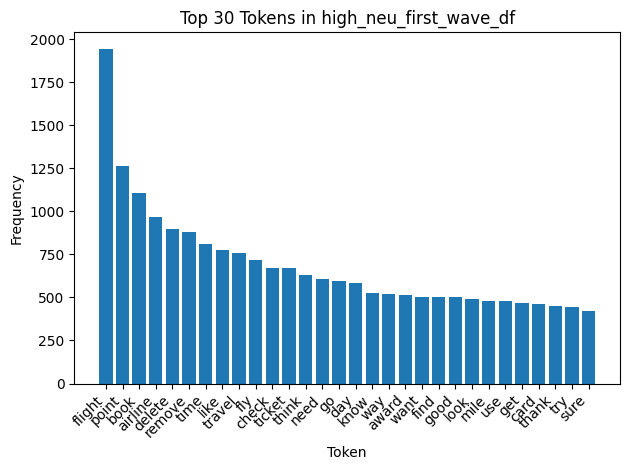

In [113]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# 1) Flatten your tokens into one long list
all_tokens = [t for toks in high_neu_first_wave_df['tokens'] for t in toks]

# 2) Build a frequency distribution
freq = Counter(all_tokens)
common = freq.most_common(30)   # top 30

# 3) Turn it into a DataFrame for easy inspection
df_freq = pd.DataFrame(common, columns=['token','count'])
print(df_freq)

# 4) Plot a simple bar chart of the top tokens
tokens, counts = zip(*common)
plt.figure()
plt.bar(tokens, counts)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.title('Top 30 Tokens in high_neu_first_wave_df')
plt.tight_layout()
plt.show()

In [114]:
# Flatten all tokens into one list
all_words   = [word for tokens in high_neu_first_wave_df['tokens'] for word in tokens]

# Compute the length (in tokens) of each post
post_length = [len(tokens) for tokens in high_neu_first_wave_df['tokens']]

# Build the vocabulary
vocab       = sorted(set(all_words))

# Print your summary stats
print(f"{len(all_words)} words total, with a vocabulary size of {len(vocab)}")
print(f"Max reddit post length is {max(post_length)} tokens")
print(f"Mean reddit post length is {sum(post_length)/len(post_length):.2f} tokens")
print(f"Median reddit post length is {sorted(post_length)[len(post_length)//2]} tokens")


108245 words total, with a vocabulary size of 8436
Max reddit post length is 286 tokens
Mean reddit post length is 13.88 tokens
Median reddit post length is 7 tokens


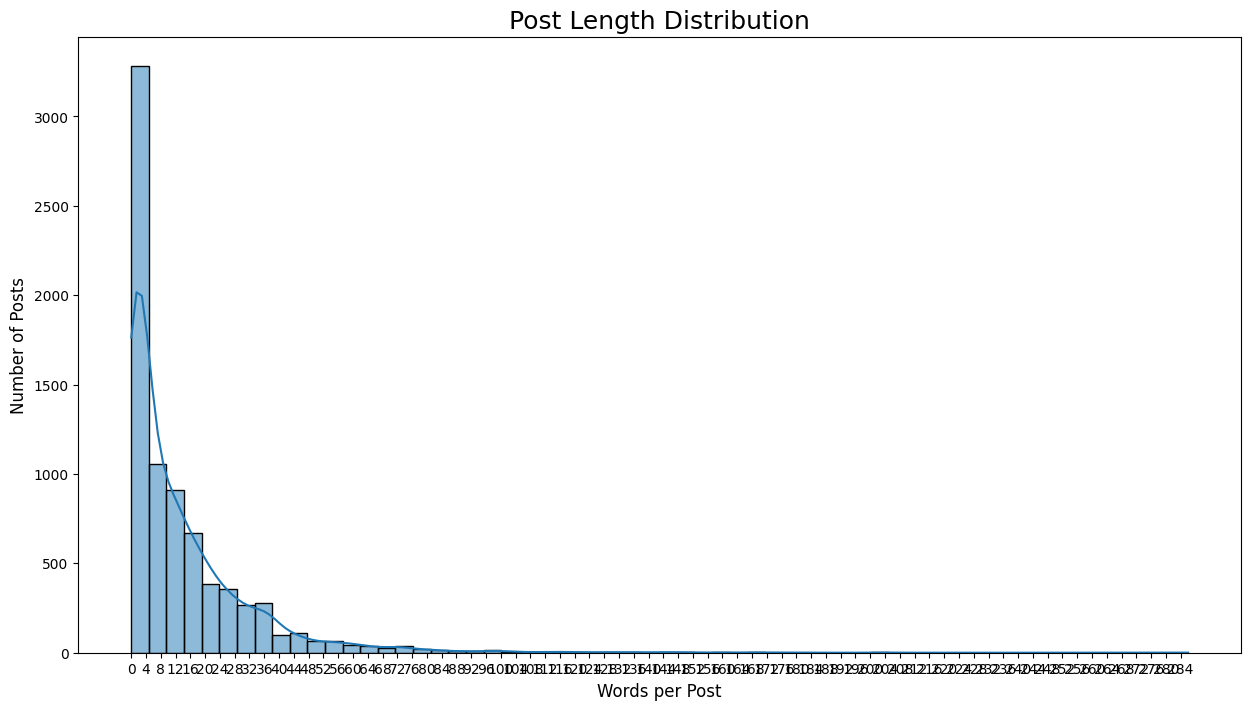

In [115]:
plt.figure(figsize=(15, 8))
sns.histplot(post_length, bins=60, kde=True)
plt.title('Post Length Distribution', fontsize=18)
plt.xlabel('Words per Post', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)
# Setting x-axis ticks and labels for more detail
max_length = max(post_length)
xticks = np.arange(0, max_length + 1, max_length // 60)
plt.xticks(xticks)
plt.show()

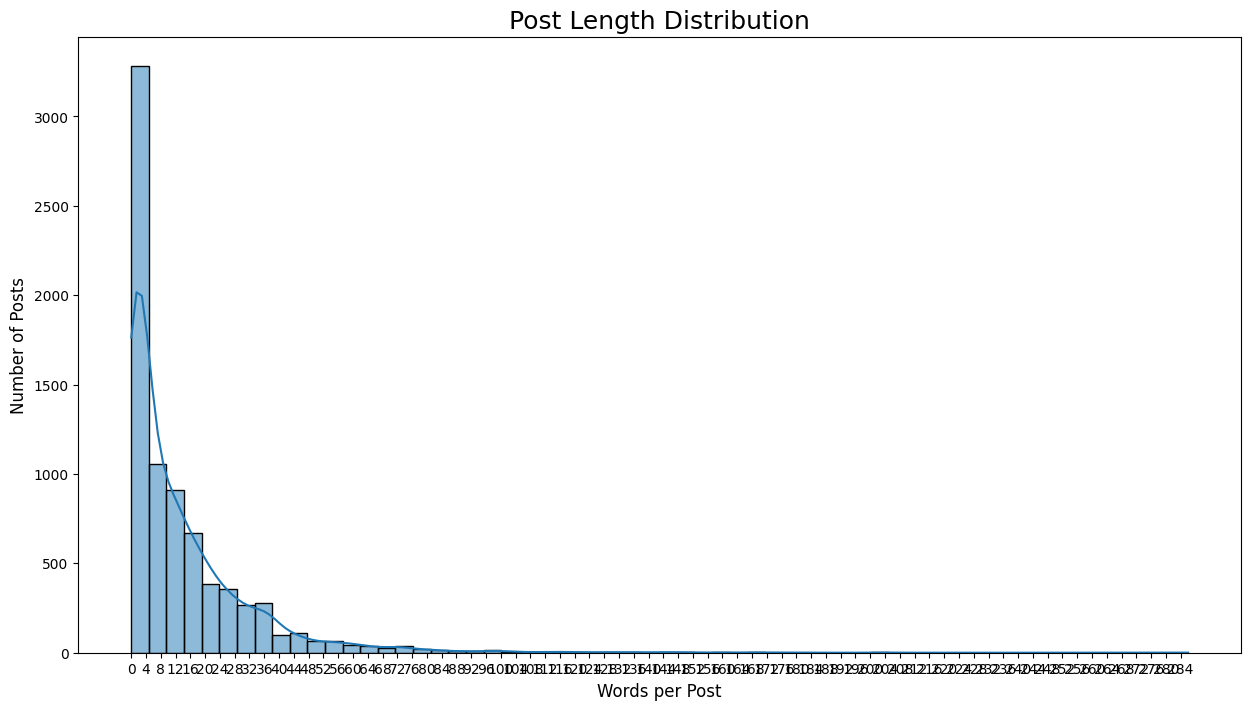

In [116]:
plt.figure(figsize=(15, 8))
sns.histplot(post_length, bins=60, kde=True)
plt.title('Post Length Distribution', fontsize=18)
plt.xlabel('Words per Post', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)
# Setting x-axis ticks and labels for more detail
max_length = max(post_length)
xticks = np.arange(0, max_length + 1, max_length // 60)
plt.xticks(xticks)
plt.show()

In [117]:
!pip install  gensim

# #1) Downgrade NumPy to 1.26.x
# !pip install numpy==1.26.0 --upgrade

# # 2) Force-reinstall Gensim so it compiles against the new NumPy
# !pip install --upgrade --force-reinstall gensim


In [118]:
import gensim
from gensim.models import Phrases
from gensim.models.phrases import Phraser

# 1) Prepare your list-of-lists from the `tokens` column
texts = high_neu_first_wave_df['tokens'].tolist()

# 2) Train the bigram detector
bigram = Phrases(texts, min_count=3, threshold=60)
bigram_mod = Phraser(bigram)

# 3) Train the trigram detector on the bigram-transformed texts
trigram = Phrases(bigram[texts], min_count=2, threshold=150)
trigram_mod = Phraser(trigram)

# 4) Apply bigram and trigram transforms
high_neu_first_wave_df['bigram_tokens']   = high_neu_first_wave_df['tokens'].apply(lambda doc: bigram_mod[doc])
high_neu_first_wave_df['trigram_tokens']  = high_neu_first_wave_df['tokens'].apply(lambda doc: trigram_mod[bigram_mod[doc]])

# #
# high_neu_first_wave_df['bigram_text']   = high_neu_first_wave_df['bigram_tokens'].str.join(' ')
# high_neu_first_wave_df['trigram_text']  = high_neu_first_wave_df['trigram_tokens'].str.join(' ')

# 6) Inspect
print(high_neu_first_wave_df[['tokens','bigram_tokens','trigram_tokens']].head())


                                                  tokens  \
44025                    [sure, asia, go, cancelrebooke]   
44031  [way, mitigate, risk, like, website, award, fl...   
44034  [september, far, lot, time, thing, change, hol...   
44035                                           [delete]   
44044  [southwest, matter, award, space, base, prevai...   

                                           bigram_tokens  \
44025                    [sure, asia, go, cancelrebooke]   
44031  [way, mitigate, risk, like, website, award, fl...   
44034  [september, far, lot, time, thing, change, hol...   
44035                                           [delete]   
44044  [southwest, matter, award, space, base, prevai...   

                                          trigram_tokens  
44025                    [sure, asia, go, cancelrebooke]  
44031  [way, mitigate, risk, like, website, award, fl...  
44034  [september, far, lot, time, thing, change, hol...  
44035                                     

In [119]:
# 1) Helper to detect n-grams in a token list
def contains_ngram(tokenized_list, n):
    return any(len(tok.split('_')) == n for tok in tokenized_list)

# 2) Flag rows
high_neu_first_wave_df['has_bigrams']  = high_neu_first_wave_df['bigram_tokens'].apply(lambda doc: contains_ngram(doc, 2))
high_neu_first_wave_df['has_trigrams'] = high_neu_first_wave_df['trigram_tokens'].apply(lambda doc: contains_ngram(doc, 3))

# 3) Count
rows_with_bigrams  = high_neu_first_wave_df['has_bigrams'].sum()
rows_with_trigrams = high_neu_first_wave_df['has_trigrams'].sum()
rows_with_none     = (~high_neu_first_wave_df['has_bigrams'] & ~high_neu_first_wave_df['has_trigrams']).sum()

# 4) Report
print(f"Rows with bigrams:   {rows_with_bigrams}")
print(f"Rows with trigrams:  {rows_with_trigrams}")
print(f"Rows with no n-grams: {rows_with_none}")


Rows with bigrams:   1615
Rows with trigrams:  167
Rows with no n-grams: 6184


In [120]:
high_neu_first_wave_df.head()

,created_utc,label,score,cleaned_text,tokens,final_text,bigram_tokens,trigram_tokens,has_bigrams,has_trigrams
44025,2022-01-31,mild neu,0.667773,sure something asia going keep cancelrebooking,"[sure, asia, go, cancelrebooke]",sure asia go cancelrebooke,"[sure, asia, go, cancelrebooke]","[sure, asia, go, cancelrebooke]",False,False
44031,2022-01-31,mild neu,0.730467,way mitigate risk like website see award fligh...,"[way, mitigate, risk, like, website, award, fl...",way mitigate risk like website award flight av...,"[way, mitigate, risk, like, website, award, fl...","[way, mitigate, risk, like, website, award, fl...",False,False
44034,2022-01-31,mild neu,0.736328,september far enough there still lot time thin...,"[september, far, lot, time, thing, change, hol...",september far lot time thing change hold idea ...,"[september, far, lot, time, thing, change, hol...","[september, far, lot, time, thing, change, hol...",False,False
44035,2022-01-31,mild neu,0.593584,deleted,[delete],delete,[delete],[delete],False,False
44044,2022-01-31,mild neu,0.699681,southwest wont matter dont award space per se ...,"[southwest, matter, award, space, base, prevai...",southwest matter award space base prevail pric...,"[southwest, matter, award, space, base, prevai...","[southwest, matter, award, space, base, prevai...",False,False


In [121]:
# Print the total number of rows in the DataFrame
total_rows = high_neu_first_wave_df.shape[0]
print(f"Total number of rows in the DataFrame: {total_rows}")

# Check the number of rows in the 'trigram_tokenized' column
print(f"Number of rows in 'trigram_tokenized' column: {high_neu_first_wave_df['trigram_tokens'].shape[0]}")

Total number of rows in the DataFrame: 7799
Number of rows in 'trigram_tokenized' column: 7799


In [122]:
import itertools
from collections import Counter

# 1) Flatten all trigram lists into one big sequence
all_trigrams = itertools.chain.from_iterable(high_neu_first_wave_df['trigram_tokens'])

# 2) Filter for genuine trigrams (exactly two underscores → three words joined)
trigram_counts = Counter(
    token for token in all_trigrams
    if isinstance(token, str) and token.count('_') == 2
)

# 3) How many unique trigrams?
total_unique_trigrams = len(trigram_counts)
print(f"Total number of unique trigrams: {total_unique_trigrams}")

# 4) Show the 10 most common trigrams
print("\nMost common trigrams:")
for trigram, count in trigram_counts.most_common(10):
    print(f"{trigram}: {count:,}")


Total number of unique trigrams: 27

Most common trigrams:
remove_contact_mod: 90
subreddit_redeem_point: 72
subreddit_submission_remove: 72
rchurne_instead_think: 72
think_post_mistakenly: 18
allow_post_buying: 17
redemption_trip_strongly: 15
flying_feel_free: 14
mile_post_adhere: 14
start_bot_action: 14


In [123]:
#import gensim.corpora as corpora
# Create Dictionary
#id2word = corpora.Dictionary(high_neu_first_wave_df['trigram_tokens'].tolist())

## pruning
#id2word.filter_extremes(no_below=5, no_above=0.5)

#    (Optional) Re-map the remaining token IDs to remove gaps
#id2word.compactify()

# 2. Convert each document to a Bag-of-Words
# texts = high_neu_first_wave_df['trigram_tokens'].tolist()

# # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]


# # View
# print(corpus[:1][0][:30])

In [124]:
# import gensim
# from gensim import corpora
# from gensim.models.ldamodel import LdaModel
# from nltk.tokenize import word_tokenize
# import nltk
# ## Build the basic LDA model
# lda_model = LdaModel(corpus=corpus,
#                                        id2word=id2word,
#                                        num_topics=3,
#                                        random_state=100,
#                                           chunksize=200,
#                                        passes=50,
#                                         iterations= 100,
#                                        alpha='auto',
#                                       eta='auto',
#                                        per_word_topics=True)

In [125]:
# from pprint import pprint

# # Print the Keyword in the 3 topics
# pprint(lda_model.print_topics())
# doc_lda = lda_model[corpus]

In [126]:
high_neu_first_wave_df.head()

,created_utc,label,score,cleaned_text,tokens,final_text,bigram_tokens,trigram_tokens,has_bigrams,has_trigrams
44025,2022-01-31,mild neu,0.667773,sure something asia going keep cancelrebooking,"[sure, asia, go, cancelrebooke]",sure asia go cancelrebooke,"[sure, asia, go, cancelrebooke]","[sure, asia, go, cancelrebooke]",False,False
44031,2022-01-31,mild neu,0.730467,way mitigate risk like website see award fligh...,"[way, mitigate, risk, like, website, award, fl...",way mitigate risk like website award flight av...,"[way, mitigate, risk, like, website, award, fl...","[way, mitigate, risk, like, website, award, fl...",False,False
44034,2022-01-31,mild neu,0.736328,september far enough there still lot time thin...,"[september, far, lot, time, thing, change, hol...",september far lot time thing change hold idea ...,"[september, far, lot, time, thing, change, hol...","[september, far, lot, time, thing, change, hol...",False,False
44035,2022-01-31,mild neu,0.593584,deleted,[delete],delete,[delete],[delete],False,False
44044,2022-01-31,mild neu,0.699681,southwest wont matter dont award space per se ...,"[southwest, matter, award, space, base, prevai...",southwest matter award space base prevail pric...,"[southwest, matter, award, space, base, prevai...","[southwest, matter, award, space, base, prevai...",False,False


In [127]:
# from gensim.models import CoherenceModel

# # Compute Coherence Score
# coherence_model_lda = CoherenceModel(model=lda_model, texts=high_neu_first_wave_df['trigram_tokenized'], dictionary=id2word, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()
# print('Coherence Score: ', coherence_lda)

In [128]:
# import pyLDAvis.gensim
# import pickle
# import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis
# import pyLDAvis

# # Assuming ldamodel, corpus, and dictionary are already defined
# # Enable the automatic display of visualizations in Jupyter
# pyLDAvis.enable_notebook()

# # Prepare the LDA visualization directly
# LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)

# # Display the prepared visualization directly in the notebook
# pyLDAvis.display(LDAvis_prepared)

In [129]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pandas as pd
import numpy as np
import itertools

# Assuming high_pos_df['trigram_tokenized'] contains lists of lemmatized trigram tokens
texts = high_neu_first_wave_df['trigram_tokens'].tolist()

# Create a Dictionary and Corpus
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Function to compute coherence and perplexity
def compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations, seed):
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=seed,
                         chunksize=chunksize,
                         passes=passes,
                         iterations=iterations,
                         alpha='auto',
                         eta='auto',
                         per_word_topics=True)

    perplexity = lda_model.log_perplexity(corpus)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model_lda.get_coherence()

     # Extract alpha and eta
    alpha = lda_model.alpha
    eta = lda_model.eta
    return perplexity, coherence, alpha, eta

# Define the parameter grid with your specific values
seeds = [0, 1, 2]
num_topics_range = range(2, 10)  # Adjust the range based on your needs
chunksize_range = [1000]
passes_range = [100, 200,260]
iterations_range = [50,100, 200]

# Store results
results = []

# Grid search over all combinations of hyperparameters
for seed in [0, 1, 2]:
 for num_topics, chunksize, passes, iterations in itertools.product(num_topics_range, chunksize_range, passes_range, iterations_range):
    perplexity, coherence , alpha, eta = compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations, seed)
    results.append((num_topics, chunksize, passes, iterations, perplexity, coherence,alpha,eta,seed))
    print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f} ,Alpha: {alpha}, Eta: {eta}")

# Convert results to a DataFrame for better analysis
results_df = pd.DataFrame(results, columns=['num_topics', 'chunksize', 'passes', 'iterations', 'perplexity', 'coherence','alpha','eta', 'seed'])
# Add exponentiated perplexity column
results_df['perplexity_exp'] = np.exp(-results_df['perplexity'])

# Display results
print("\nResults:")
print(results_df)

# Find the optimal number of topics with the highest coherence
optimal_result = results_df.sort_values(
    by=['coherence', 'perplexity_exp'],
    ascending=[False, True]
).iloc[0]
optimal_num_topics = optimal_result['num_topics']
optimal_chunksize = optimal_result['chunksize']
optimal_passes = optimal_result['passes']
optimal_iterations = optimal_result['iterations']
optimal_perplexity = optimal_result['perplexity_exp']
optimal_coherence = optimal_result['coherence']
optimal_alpha = optimal_result['alpha']
optimal_eta   = optimal_result['eta']
optimal_seed = optimal_result['seed']

print(f"\nOptimal Parameters:")
print(f"Number of Topics: {optimal_num_topics}")
print(f"Chunksize: {optimal_chunksize}")
print(f"Passes: {optimal_passes}")
print(f"Iterations: {optimal_iterations}")
print(f"Coherence: {optimal_coherence:.4f}")
print(f"Perplexity: {optimal_perplexity:.4f}")
print(f" Alpha (per topic): {optimal_alpha}")
print(f" Eta   (per word):  {optimal_eta}")
print(f" seed:  {optimal_seed}")

Num Topics: 2, Chunksize: 1000, Passes: 100, Iterations: 50, Perplexity: -7.3299, Coherence: 0.7089 ,Alpha: [0.14868738 0.12197232], Eta: [ 4.1274147   0.35284045 42.65623    ...  0.36688286  0.36689162
  0.3668919 ]


Num Topics: 2, Chunksize: 1000, Passes: 100, Iterations: 100, Perplexity: -7.3319, Coherence: 0.7071 ,Alpha: [0.15789992 0.12057164], Eta: [ 4.2155204   0.3519129  41.423637   ...  0.36584687  0.36585584
  0.3658561 ]


Num Topics: 2, Chunksize: 1000, Passes: 100, Iterations: 200, Perplexity: -7.3341, Coherence: 0.7140 ,Alpha: [0.16644128 0.12226012], Eta: [ 4.1314387   0.34954062 40.055058   ...  0.3632817   0.36329034
  0.36329058]


Num Topics: 2, Chunksize: 1000, Passes: 200, Iterations: 50, Perplexity: -7.3203, Coherence: 0.7096 ,Alpha: [0.1090882  0.10133956], Eta: [ 4.179942    0.36269966 46.227875   ...  0.37633505  0.37634414
  0.3763444 ]


Num Topics: 2, Chunksize: 1000, Passes: 200, Iterations: 100, Perplexity: -7.3216, Coherence: 0.7129 ,Alpha: [0.11276051 0.09944124], Eta: [ 4.3816595   0.36234567 45.810192   ...  0.37592983  0.37593898
  0.37593928]


Num Topics: 2, Chunksize: 1000, Passes: 200, Iterations: 200, Perplexity: -7.3254, Coherence: 0.7097 ,Alpha: [0.1278697 0.1047952], Eta: [ 4.3937354   0.3589402  43.658195   ...  0.3722559   0.37226525
  0.37226546]


Num Topics: 2, Chunksize: 1000, Passes: 260, Iterations: 50, Perplexity: -7.3163, Coherence: 0.7096 ,Alpha: [0.09486719 0.09322916], Eta: [ 4.1684      0.36681494 47.779976   ...  0.3804756   0.380484
  0.38048425]


Num Topics: 2, Chunksize: 1000, Passes: 260, Iterations: 100, Perplexity: -7.3192, Coherence: 0.7135 ,Alpha: [0.10350806 0.09416658], Eta: [ 4.421016    0.3648174  46.661293   ...  0.3783085   0.37831718
  0.37831742]


Num Topics: 2, Chunksize: 1000, Passes: 260, Iterations: 200, Perplexity: -7.3226, Coherence: 0.7176 ,Alpha: [0.11748292 0.09960744], Eta: [ 4.4713345   0.3619725  44.97656    ...  0.3752386   0.37524763
  0.37524787]
Num Topics: 3, Chunksize: 1000, Passes: 100, Iterations: 50, Perplexity: -7.3581, Coherence: 0.6033 ,Alpha: [0.29461122 0.08186376 0.18090633], Eta: [1.939879   0.2356705  2.1544926  ... 0.24093205 0.24872397 0.24212916]
Num Topics: 3, Chunksize: 1000, Passes: 100, Iterations: 100, Perplexity: -7.3501, Coherence: 0.6399 ,Alpha: [0.21640277 0.04706369 0.14908133], Eta: [0.7136123  0.24241039 2.2110128  ... 0.24796562 0.26312315 0.24944964]
Num Topics: 3, Chunksize: 1000, Passes: 100, Iterations: 200, Perplexity: -7.3498, Coherence: 0.6448 ,Alpha: [0.19237873 0.04413794 0.14943533], Eta: [0.68885845 0.24167795 2.245471   ... 0.24719884 0.25874525 0.24843723]
Num Topics: 3, Chunksize: 1000, Passes: 200, Iterations: 50, Perplexity: -7.3518, Coherence: 0.6035 ,Alpha: [0.238502

Num Topics: 2, Chunksize: 1000, Passes: 100, Iterations: 50, Perplexity: -7.3288, Coherence: 0.6955 ,Alpha: [0.23156855 0.10282227], Eta: [ 0.885475    0.35099894 35.70491    ...  0.3656312   0.3979517
  0.3652407 ]


Num Topics: 2, Chunksize: 1000, Passes: 100, Iterations: 100, Perplexity: -7.3275, Coherence: 0.6979 ,Alpha: [0.21313567 0.09954481], Eta: [ 0.895643    0.35238913 36.69312    ...  0.36708984  0.39833906
  0.36673182]


Num Topics: 2, Chunksize: 1000, Passes: 100, Iterations: 200, Perplexity: -7.3265, Coherence: 0.6979 ,Alpha: [0.20137383 0.09624827], Eta: [ 0.9190077   0.35345125 37.380043   ...  0.36821094  0.39986673
  0.36787152]


Num Topics: 2, Chunksize: 1000, Passes: 200, Iterations: 50, Perplexity: -7.3158, Coherence: 0.7132 ,Alpha: [0.1320153  0.06992795], Eta: [ 0.9623506   0.36596632 42.56042    ...  0.3803423   0.40581766
  0.38007963]


Num Topics: 2, Chunksize: 1000, Passes: 200, Iterations: 100, Perplexity: -7.3156, Coherence: 0.6956 ,Alpha: [0.12823369 0.0693384 ], Eta: [ 0.9629234   0.3660899  42.72207    ...  0.38046667  0.4046802
  0.38021082]


Num Topics: 2, Chunksize: 1000, Passes: 200, Iterations: 200, Perplexity: -7.3154, Coherence: 0.6956 ,Alpha: [0.12580372 0.06832094], Eta: [ 0.98556405  0.3662124  42.859673   ...  0.38059554  0.40498215
  0.38034162]


Num Topics: 2, Chunksize: 1000, Passes: 260, Iterations: 50, Perplexity: -7.3137, Coherence: 0.7132 ,Alpha: [0.1191345  0.06425671], Eta: [ 0.97415525  0.36830905 43.582935   ...  0.3825463   0.40583906
  0.38229576]


Num Topics: 2, Chunksize: 1000, Passes: 260, Iterations: 100, Perplexity: -7.3140, Coherence: 0.7132 ,Alpha: [0.1188269  0.06487475], Eta: [ 0.9714811   0.3678959  43.532513   ...  0.38209915  0.40486285
  0.38185364]


Num Topics: 2, Chunksize: 1000, Passes: 260, Iterations: 200, Perplexity: -7.3139, Coherence: 0.7132 ,Alpha: [0.1181521  0.06479838], Eta: [ 0.99254566  0.3679149  43.577847   ...  0.3821176   0.40507394
  0.3818737 ]
Num Topics: 3, Chunksize: 1000, Passes: 100, Iterations: 50, Perplexity: -7.3754, Coherence: 0.6967 ,Alpha: [0.5392341  0.46605346 0.32302344], Eta: [0.3518767  0.23178613 9.48652    ... 0.2407397  0.24339733 0.24075332]
Num Topics: 3, Chunksize: 1000, Passes: 100, Iterations: 100, Perplexity: -7.3471, Coherence: 0.7091 ,Alpha: [0.1804163  0.26748013 0.22404216], Eta: [ 0.62821656  0.23575783 19.850094   ...  0.25048986  0.27279645
  0.24221793]
Num Topics: 3, Chunksize: 1000, Passes: 100, Iterations: 200, Perplexity: -7.3398, Coherence: 0.7131 ,Alpha: [0.12919804 0.20835924 0.16651967], Eta: [ 0.6171893   0.2375275  20.275951   ...  0.24281922  0.25505787
  0.24375494]
Num Topics: 3, Chunksize: 1000, Passes: 200, Iterations: 50, Perplexity: -7.3671, Coherence: 0.6962 ,Al

Num Topics: 2, Chunksize: 1000, Passes: 100, Iterations: 50, Perplexity: -7.3174, Coherence: 0.6915 ,Alpha: [0.10257287 0.09024057], Eta: [ 1.0247924   0.36351234 45.948257   ...  0.37878355  0.38783774
  0.37865937]


Num Topics: 2, Chunksize: 1000, Passes: 100, Iterations: 100, Perplexity: -7.3220, Coherence: 0.7032 ,Alpha: [0.10525499 0.09947819], Eta: [ 1.0035214   0.36094546 44.3807     ...  0.37605855  0.38790527
  0.3759042 ]


Num Topics: 2, Chunksize: 1000, Passes: 100, Iterations: 200, Perplexity: -7.3221, Coherence: 0.7032 ,Alpha: [0.10397602 0.09922457], Eta: [ 1.0005455   0.36090875 44.36045    ...  0.37602586  0.38794902
  0.3758655 ]


Num Topics: 2, Chunksize: 1000, Passes: 200, Iterations: 50, Perplexity: -7.3120, Coherence: 0.6915 ,Alpha: [0.09005046 0.0778969 ], Eta: [ 1.0525484   0.36978805 47.8114     ...  0.38426584  0.39135495
  0.38415107]


Num Topics: 2, Chunksize: 1000, Passes: 200, Iterations: 100, Perplexity: -7.3139, Coherence: 0.6863 ,Alpha: [0.08650605 0.07783812], Eta: [ 1.0524209   0.37020043 47.49282    ...  0.38472828  0.39382857
  0.38459495]


Num Topics: 2, Chunksize: 1000, Passes: 200, Iterations: 200, Perplexity: -7.3142, Coherence: 0.6863 ,Alpha: [0.08696723 0.0794307 ], Eta: [ 1.0452226   0.36975884 47.302845   ...  0.3842633   0.3936145
  0.38412315]


Num Topics: 2, Chunksize: 1000, Passes: 260, Iterations: 50, Perplexity: -7.3112, Coherence: 0.6915 ,Alpha: [0.08807682 0.07638043], Eta: [ 1.0548155   0.37072867 47.99814    ...  0.3849802   0.39174208
  0.38486642]


Num Topics: 2, Chunksize: 1000, Passes: 260, Iterations: 100, Perplexity: -7.3129, Coherence: 0.6863 ,Alpha: [0.08411299 0.07588094], Eta: [ 1.0563413   0.3712284  47.706154   ...  0.38553348  0.39415854
  0.38540268]


Num Topics: 2, Chunksize: 1000, Passes: 260, Iterations: 200, Perplexity: -7.3131, Coherence: 0.6863 ,Alpha: [0.08363107 0.07632035], Eta: [ 1.0532395   0.37115735 47.69536    ...  0.38546413  0.3941881
  0.38532743]
Num Topics: 3, Chunksize: 1000, Passes: 100, Iterations: 50, Perplexity: -7.3437, Coherence: 0.5682 ,Alpha: [0.24581032 0.41108283 0.06756858], Eta: [ 0.345794    0.2338102  11.052574   ...  0.23920794  0.24731503
  0.23891611]
Num Topics: 3, Chunksize: 1000, Passes: 100, Iterations: 100, Perplexity: -7.3483, Coherence: 0.5312 ,Alpha: [0.23516046 0.4756441  0.06403556], Eta: [0.34471443 0.23389637 2.0126696  ... 0.23952755 0.2541382  0.2390168 ]
Num Topics: 3, Chunksize: 1000, Passes: 100, Iterations: 200, Perplexity: -7.3491, Coherence: 0.5315 ,Alpha: [0.2114109 0.4900811 0.0636223], Eta: [0.3469223  0.23469171 1.8062694  ... 0.24053043 0.25585935 0.23987168]
Num Topics: 3, Chunksize: 1000, Passes: 200, Iterations: 50, Perplexity: -7.3384, Coherence: 0.5647 ,Alpha: [0.218

In [130]:
# 1. Fit the model
lda_opt = LdaModel(
    corpus        = corpus,
    id2word       = dictionary,
    num_topics    = optimal_num_topics,
    chunksize     = optimal_chunksize,
    passes        = optimal_passes,
    iterations    = optimal_iterations,
    alpha         = 'auto',
    eta           = 'auto',
    random_state  = optimal_seed,
    per_word_topics=True
)

# 2. Extract metrics and priors
opt_perp  = lda_opt.log_perplexity(corpus)
opt_coh   = CoherenceModel(model=lda_opt, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
opt_alpha = lda_opt.alpha
opt_eta   = lda_opt.eta

print(f"Re-fitted Optimal Model:")
print(f" Coherence: {opt_coh:.4f}")
print(f" Perplexity: {opt_perp:.4f}")
print(f" Alpha (per topic): {opt_alpha}")
print(f" Eta   (per word):  {opt_eta}")


Re-fitted Optimal Model:
 Coherence: 0.7205
 Perplexity: -7.3281
 Alpha (per topic): [0.11139143 0.15517533 0.13371435]
 Eta   (per word):  [ 0.66955185  0.2413205  21.564629   ...  0.24622555  0.25608042
  0.2469334 ]


In [131]:
lda_opt.save('/content/drive/MyDrive/lda_model_neutral_4th_wave.gensim')


In [132]:
import numpy as np
from google.colab import files

# 1. Grab your metrics & hyper‐params
coherence_val  = opt_coh
perplexity_val = opt_perp
alpha_val      = opt_alpha
eta_vals       = opt_eta  # full array

# 2. Write them into a single text file
with open('lda_model_full_summary_3rd_mild_neu.txt', 'w') as f:
    f.write("Re-fitted Optimal Model:\n")
    f.write(f" Coherence:  {coherence_val:.4f}\n")
    f.write(f" Perplexity: {perplexity_val:.4f}\n")
    f.write(f" Alpha:      {alpha_val}\n")
    f.write(" Eta values:\n")
    for eta in eta_vals:
        f.write(f"{eta}\n")

# 3. Trigger the download
files.download('lda_model_full_summary_3rd_mild_neu.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [133]:
#  3: verify that the refit recovered the same priors
import numpy as np

print("Alpha match:", np.allclose(optimal_alpha, opt_alpha))
print("Eta   match:", np.allclose(optimal_eta,   opt_eta))


Alpha match: True
Eta   match: True


In [134]:
#  1: Imports
from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

#  2: Print topics & sample document–topic distribution
print("=== Topics ===")
pprint(lda_opt.print_topics())

doc_topics = [lda_opt.get_document_topics(doc) for doc in corpus]
print("\nSample doc-topic distribution for doc 0:")
pprint(doc_topics[0])



=== Topics ===
[(0,
  '0.034*"delete" + 0.029*"point" + 0.013*"night" + 0.011*"hotel" + '
  '0.010*"stay" + 0.010*"status" + 0.008*"travel" + 0.008*"use" + '
  '0.008*"hyatt" + 0.007*"like"'),
 (1,
  '0.016*"remove" + 0.013*"flight" + 0.011*"time" + 0.010*"check" + '
  '0.010*"need" + 0.009*"hour" + 0.008*"airport" + 0.008*"travel" + '
  '0.007*"airline" + 0.007*"like"'),
 (2,
  '0.034*"flight" + 0.021*"book" + 0.017*"airline" + 0.016*"ticket" + '
  '0.012*"fly" + 0.010*"award" + 0.008*"cancel" + 0.008*"find" + '
  '0.007*"change" + 0.007*"mile"')]

Sample doc-topic distribution for doc 0:
[(0, 0.025375476), (1, 0.0355297), (2, 0.9390948)]


In [135]:
# Cell 3: pyLDAvis visualization
# (make sure you’ve run `%matplotlib inline` or enabled notebook output)
pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_opt, corpus, dictionary)
pyLDAvis.display(vis_data)


In [136]:
#  4: Print the top 30 terms per topic
print("\n=== Top 30 terms per topic ===")
for topic_id, term_weights in lda_opt.show_topics(
        num_topics=lda_opt.num_topics,
        num_words=30,
        formatted=False):
    print(f"Topic {topic_id + 1}:")
    for word, weight in term_weights:
        print(f"  {word} ({weight:.4f})")
    print()



=== Top 30 terms per topic ===
Topic 1:
  delete (0.0343)
  point (0.0291)
  night (0.0129)
  hotel (0.0115)
  stay (0.0105)
  status (0.0100)
  travel (0.0083)
  use (0.0078)
  hyatt (0.0077)
  like (0.0072)
  year (0.0069)
  card (0.0067)
  book (0.0062)
  good (0.0062)
  pay (0.0061)
  free (0.0057)
  chase (0.0056)
  value (0.0056)
  think (0.0056)
  cash (0.0056)
  spend (0.0055)
  go (0.0055)
  get (0.0053)
  well (0.0052)
  room (0.0049)
  marriott (0.0048)
  want (0.0047)
  transfer (0.0046)
  worth (0.0046)
  upgrade (0.0046)

Topic 2:
  remove (0.0159)
  flight (0.0131)
  time (0.0110)
  check (0.0103)
  need (0.0099)
  hour (0.0091)
  airport (0.0079)
  travel (0.0075)
  airline (0.0072)
  like (0.0066)
  know (0.0065)
  bag (0.0065)
  day (0.0062)
  country (0.0062)
  ask (0.0060)
  test (0.0060)
  go (0.0054)
  sure (0.0050)
  think (0.0050)
  covid (0.0049)
  fly (0.0048)
  people (0.0047)
  long (0.0046)
  say (0.0046)
  get (0.0044)
  issue (0.0041)
  work (0.0039)
  t

In [137]:
# import gensim.corpora as corpora
# # Create Dictionary
# id2word = corpora.Dictionary(high_neu_first_wave_df['trigram_tokens'].tolist())

# ## pruning
# id2word.filter_extremes(no_below=5, no_above=0.7)

# #    (Optional) Re-map the remaining token IDs to remove gaps
# id2word.compactify()

# # 2. Convert each document to a Bag-of-Words
# texts = high_neu_first_wave_df['trigram_tokens'].tolist()

# # # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]


# # # View
# print(corpus[:1][0][:30])

In [138]:
# import gensim
# from gensim import corpora
# from gensim.models import LdaModel
# from gensim.models.coherencemodel import CoherenceModel
# import pandas as pd
# import numpy as np
# import itertools


# # Create a Dictionary and Corpus
# dictionary = id2word


# # Function to compute coherence and perplexity
# def compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations):
#     lda_model = LdaModel(corpus=corpus,
#                          id2word=dictionary,
#                          num_topics=num_topics,
#                          random_state=100,
#                          chunksize=chunksize,
#                          passes=passes,
#                          iterations=iterations,
#                          alpha='auto',
#                          eta='auto',
#                          per_word_topics=True)

#     perplexity = lda_model.log_perplexity(corpus)
#     coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
#     coherence = coherence_model_lda.get_coherence()

#      # Extract alpha and eta
#     alpha = lda_model.alpha
#     eta = lda_model.eta
#     return perplexity, coherence, alpha, eta

# # Define the parameter grid with your specific values
# num_topics_range = range(2, 10)  # Adjust the range based on your needs
# chunksize_range = [250]
# passes_range = [100, 200,260]
# iterations_range = [50,100, 200]

# # Store results
# results = []

# # Grid search over all combinations of hyperparameters
# for num_topics, chunksize, passes, iterations in itertools.product(num_topics_range, chunksize_range, passes_range, iterations_range):
#     perplexity, coherence , alpha, eta = compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations)
#     results.append((num_topics, chunksize, passes, iterations, perplexity, coherence,alpha,eta))
#     print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f} ,Alpha: {alpha}, Eta: {eta}")

# # Convert results to a DataFrame for better analysis
# results_df = pd.DataFrame(results, columns=['num_topics', 'chunksize', 'passes', 'iterations', 'perplexity', 'coherence','alpha','eta'])
# # Add exponentiated perplexity column
# results_df['perplexity_exp'] = np.exp(-results_df['perplexity'])

# # Display results
# print("\nResults:")
# print(results_df)

# # Find the optimal number of topics with the highest coherence
# optimal_result = results_df.sort_values(
#     by=['coherence', 'perplexity_exp'],
#     ascending=[False, True]
# ).iloc[0]
# optimal_num_topics = optimal_result['num_topics']
# optimal_chunksize = optimal_result['chunksize']
# optimal_passes = optimal_result['passes']
# optimal_iterations = optimal_result['iterations']
# optimal_perplexity = optimal_result['perplexity_exp']
# optimal_coherence = optimal_result['coherence']
# optimal_alpha = optimal_result['alpha']
# optimal_eta   = optimal_result['eta']

# print(f"\nOptimal Parameters:")
# print(f"Number of Topics: {optimal_num_topics}")
# print(f"Chunksize: {optimal_chunksize}")
# print(f"Passes: {optimal_passes}")
# print(f"Iterations: {optimal_iterations}")
# print(f"Coherence: {optimal_coherence:.4f}")
# print(f"Perplexity: {optimal_perplexity:.4f}")
# print(f" Alpha (per topic): {optimal_alpha}")
# print(f" Eta   (per word):  {optimal_eta}")

In [139]:
# # 1. Fit the model
# lda_opt = LdaModel(
#     corpus        = corpus,
#     id2word       = dictionary,
#     num_topics    = optimal_num_topics,
#     chunksize     = optimal_chunksize,
#     passes        = optimal_passes,
#     iterations    = optimal_iterations,
#     alpha         = 'auto',
#     eta           = 'auto',
#     random_state  = 100,
#     per_word_topics=True
# )

# # 2. Extract metrics and priors
# opt_perp  = lda_opt.log_perplexity(corpus)
# opt_coh   = CoherenceModel(model=lda_opt, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
# opt_alpha = lda_opt.alpha
# opt_eta   = lda_opt.eta

# print(f"Re-fitted Optimal Model:")
# print(f" Coherence: {opt_coh:.4f}")
# print(f" Perplexity: {opt_perp:.4f}")
# print(f" Alpha (per topic): {opt_alpha}")
# print(f" Eta   (per word):  {opt_eta}")


In [140]:
# import numpy as np
# from google.colab import files

# # 1. Grab your metrics & hyper‐params
# coherence_val  = opt_coh
# perplexity_val = opt_perp
# alpha_val      = opt_alpha
# eta_vals       = opt_eta  # full array

# # 2. Write them into a single text file
# with open('lda_model_full_summary.txt', 'w') as f:
#     f.write("Re-fitted Optimal Model:\n")
#     f.write(f" Coherence:  {coherence_val:.4f}\n")
#     f.write(f" Perplexity: {perplexity_val:.4f}\n")
#     f.write(f" Alpha:      {alpha_val}\n")
#     f.write(" Eta values:\n")
#     for eta in eta_vals:
#         f.write(f"{eta}\n")

# # 3. Trigger the download
# files.download('lda_model_full_summary.txt')


In [141]:
# # Cell 3: verify that the refit recovered the same priors
# import numpy as np

# print("Alpha match:", np.allclose(optimal_alpha, opt_alpha))
# print("Eta   match:", np.allclose(optimal_eta,   opt_eta))


In [142]:
# # Cell 1: Imports
# from pprint import pprint
# import pyLDAvis.gensim_models as gensimvis
# import pyLDAvis

# # Cell 2: Print topics & sample document–topic distribution
# print("=== Topics ===")
# pprint(lda_opt.print_topics())

# doc_topics = [lda_opt.get_document_topics(doc) for doc in corpus]
# print("\nSample doc-topic distribution for doc 0:")
# pprint(doc_topics[0])



In [143]:
# # Cell 3: pyLDAvis visualization
# # (make sure you’ve run `%matplotlib inline` or enabled notebook output)
# pyLDAvis.enable_notebook()
# vis_data = gensimvis.prepare(lda_opt, corpus, dictionary)
# pyLDAvis.display(vis_data)


In [144]:
# # Cell 4: Print the top 30 terms per topic
# print("\n=== Top 30 terms per topic ===")
# for topic_id, term_weights in lda_opt.show_topics(
#         num_topics=lda_opt.num_topics,
#         num_words=30,
#         formatted=False):
#     print(f"Topic {topic_id + 1}:")
#     for word, weight in term_weights:
#         print(f"  {word} ({weight:.4f})")
#     print()


In [145]:
# ## FIND THE OPTIMAL TOPIC

# import gensim
# from gensim import corpora
# from gensim.models import LdaModel
# from gensim.models.coherencemodel import CoherenceModel
# import pandas as pd

# # Assuming high_neu_first_wave_df['lemmatized_bigrams'] contains lists of lemmatized bigram tokens
# texts = high_neu_first_wave_df['trigram_tokens'].tolist()

# # Create a Dictionary and Corpus
# dictionary = corpora.Dictionary(texts)
# corpus = [dictionary.doc2bow(text) for text in texts]

# # Function to compute coherence and perplexity
# def compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics):
#     lda_model = LdaModel(corpus=corpus,
#                                        id2word=dictionary,
#                                        num_topics=num_topics,
#                                        random_state=100,
#                                           chunksize=200,
#                                        passes=50,
#                                         iterations= 100,
#                                        alpha='auto',
#                                       eta='auto',
#                                        per_word_topics=True)
#     perplexity = lda_model.log_perplexity(corpus)
#     coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
#     coherence = coherence_model_lda.get_coherence()
#     return perplexity, coherence

# # Testing different numbers of topics
# results = []
# for num_topics in range(2, 12):  # You can adjust the range based on your needs
#     perplexity, coherence = compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics)
#     results.append((num_topics, perplexity, coherence))

# # Display results
# print("Num Topics | Perplexity | Coherence")
# for result in results:
#     print(f"{result[0]:10d} | {result[1]:10.4f} | {result[2]:10.4f}")

# # Optional: find the number of topics with the highest coherence
# optimal_num_topics = sorted(results, key=lambda x: x[2], reverse=True)[0][0]
# print(f"Optimal Number of Topics: {optimal_num_topics}")


In [146]:
# # Extracting and printing the top 30 salient terms for each topic
# num_topics = lda_model.num_topics
# num_words = 30

# for idx, topic in lda_model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False):
#     print(f"Topic {idx + 1}:")
#     for word, weight in topic:
#         print(f"  {word} ({weight:.4f})")
#     print()